## Summary of notebook:

This notebook details the results using the raw dataset (not augmented) provided in the open-source repository.

Initial results showed a significant problem of overfitting and different methods were then subsequently used to help mitigate this problem of overfitting.

In the end, the most promising intermediate solution was to augment with Gaussian noise while ensuring that all negative values were clipped to 0. This dataset is referred to as ```augmented_features_10_ue1_v2_ds.npy``` (containing the features) and ```augmented_labels_10_ue1_v2_ds.npy``` in subsequent notebooks.

In [4]:
# Configure amd test GPU
import tensorflow as tf
from tensorflow.python.client import device_lib

# Prevent automatic GPU memory pre-allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

print(tf.__version__)
# print(device_lib.list_local_devices())

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
2.9.1


### Preliminary Trial

- Only take features from the first user equipment and treat each feature as an image with one channel

In [2]:
# may delete later
# New way to import the data
import h5py
import numpy as np
import tensorflow as tf

# Open HDF5 file and access the dataset
filename = 'dataset_SNR20_outdoor.mat'
hdf5_file = h5py.File(filename, 'r')

features_dataset = hdf5_file['features']
labels_dataset = hdf5_file['labels']['position']

# Convert HDF5 dataset to NumPy array
features = np.array(features_dataset)
labels = np.array(labels_dataset)

# Prepare features for dataset
# Retrieve features from the first UE and transpose the individual matrix
features_transposed = np.zeros((3876,193,16), dtype = np.float64)
for i in range(len(features)):
    features_transposed[i] = features[i][0].T

# Prepare labels for dataset
count = 0
rp_dict = {}
# For labels, have a shape of (1,) where that number represents the class of that coordinate

for label in labels:
    rp_dict[count] = label
    count += 1

labels = np.array([i for i in range(3876)])

# Close the HDF5 file
hdf5_file.close()

# Currently, for features, have features from 3876 reference points, from 4 UEs, for (16,193) matrices
print(features_transposed.shape)
print(labels.shape)

dataset = tf.data.Dataset.from_tensor_slices((features_transposed, labels))
dataset = dataset.map(lambda x,y : (x, tf.expand_dims(y, axis = 0)))

print(dataset)

(3876, 193, 16)
(3876,)
<MapDataset element_spec=(TensorSpec(shape=(193, 16), dtype=tf.float64, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))>


2023-06-09 01:07:04.882274: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-09 01:07:05.336410: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43428 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:61:00.0, compute capability: 8.6


In [3]:
# Numeric argument refers to size of buffer used in shuffling. Larger buffer size results in more thorough shuffling but requires more memory
dataset = dataset.shuffle(1000)
# reshuffle_each_iteration = False

In [4]:
# 3. Split the dataset into train, test and validaiton set
def split_dataset(ds):
    size = len(ds)
    train_size = int(round(size*0.7))
    val_size = int(round(size*0.2))
    test_size = int(round(size*0.1))
          
    train_dataset = ds.take(train_size)
    val_dataset = ds.skip(train_size).take(val_size)
    test_dataset = ds.skip(train_size + val_size).take(test_size)

    return train_dataset, val_dataset, test_dataset

train_dataset, val_dataset, test_dataset = split_dataset(dataset)

In [5]:
print("Dataset description: ", dataset)
print("Dataset length: ", len(dataset))

Dataset description:  <ShuffleDataset element_spec=(TensorSpec(shape=(193, 16), dtype=tf.float64, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))>
Dataset length:  3876


In [7]:
# 4. Batch the dataset
# Have 3,876*0.7 = 2,713 training data points, batch into 10 batches => 2,713/10 ~ 271
# Have 3,876*0.2 = 775 validation data points, batch into 10 batches => 775/10 ~ 77
train_batch_size = 272
batched_train_dataset = train_dataset.batch(train_batch_size).cache().prefetch(tf.data.AUTOTUNE)
val_batch_size = 77
batched_val_dataset = val_dataset.batch(val_batch_size).cache().prefetch(tf.data.AUTOTUNE)

In [8]:
print(batched_train_dataset)
print(batched_val_dataset)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 193, 16), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.int64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 193, 16), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.int64, name=None))>


In [9]:
# 5. Create custom callbacks to evaluate model
class ValidationCallback(tf.keras.callbacks.Callback):
    
    def __init__(self, X_val, Y_val, batch_no):
        super(ValidationCallback,self).__init__()
        self.X_val = X_val
        self.Y_val = Y_val
        self.batch_no = batch_no
        
    # number_of_iterations = total_number_of_training_examples / batch_size
    # In this case, train example of 1,000 and batch size of 100
    # number_of_iterations over 1 epoch is 10
    # if have 5 epochs, number of iterations is 50
    
    def calc_error(self, actual, predicted):

        x_error = (actual[0] - predicted[0])**2
        y_error = (actual[1] - predicted[1])**2
        z_error = (actual[2] - predicted[2])**2

        return x_error + y_error + z_error
        
    # Have one function that reports metrics on end of every epoch
    def on_epoch_end(self, epoch, logs = None):
        
        # Get evaluation metrics
        print("\n")
        print("On epoch end, evaluating model")
        val_loss, val_accuracy = self.model.evaluate(self.X_val, self.Y_val, verbose = 1)
        
        # Get distance error metrics - RMSE
        # Get predictions for each feature heatmap in X_val
        Y_pred = self.model.predict(self.X_val, verbose = 0)
        err_sum = 0
        
        # Iterate through actual and predicted to get distance error
        for i in range(len(self.X_val)):

            # Get the coordinates for actual y
            actual_coords = rp_dict[self.Y_val[i].numpy()[0]]
            
            # Get the coordinates for predicted y
            predicted_rp = np.argmax(Y_pred[i])
            pred_coords = rp_dict[predicted_rp]
            
            # Calculate distance error
            err = self.calc_error(actual_coords, pred_coords)
            err_sum += err
            
        # Get RMSE
        rmse = np.sqrt((err_sum/len(self.X_val)))
        print(f'RMSE: {rmse}')
        logs['val_loss'] = val_loss
        logs['val_accuracy'] = val_accuracy
        logs['rmse'] = rmse

In [12]:
# 6. For each batched trained dataset, train the model with the batched dataset
# Import model and prepare model for training
# Import model
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# For simplicity sake, put model in the same directory as this notebook
from resnet import resnet18

# 7. Only handle generation of heatmap after dataset is batched to prevent error from 
# tf.data.Dataset.map() function
def generate_heatmap(features):
    
    np_res = np.zeros((len(features),193,16,1), dtype = np.float64)
    i = 0
    
    for feature in features:
        # input features is tf.tensor
        feature = feature.numpy()
        # Convert to heatmap
        feature = feature.T
        im = plt.imshow(feature)

        # plt.figure(figsize=(1e4, 1e4)) # for visualising heatmap
        # plt.show() # for visualising heatmap

        plt.close() # for preventing heatmap from showing
        plt.clf() # clear current figure when done

        colour_vals_rgba = im.cmap(im.norm(im.get_array()))
        # colour_vals_rgb = colour_vals_rgba[:, :, :3]
        # np_res[i] = colour_vals_rgb
        np_res[i] = colour_vals_rgba
        
    # Convert back to tf
    tf_res = tf.convert_to_tensor(np_res)
    return tf_res
    
class Model:
    
    def __init__(self):
            
        # Create model
        inputs = keras.Input(shape = (193, 16,1))
        outputs = resnet18(inputs, num_classes = 3876)
        self.model = keras.Model(inputs, outputs)
        
        # Compile model - Classification
        self.model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
      
        # Print out a model summary
        self.model.summary()
        
        # Print out model metrics
        print(self.model.metrics_names)
     
    def run(self, train_ds, val_ds):
        
        # Create a dictionary to store results
        self.results = {}
        batch_no = 1
        
        # Create callback to produce logs at the end of each epoch
        # logdir = 'logs'
        # tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
            
        # Iterate through all batches
        for cur_batch in train_ds:
            
            print(f'Processing batch {batch_no}')
            
            X_train = cur_batch[0]
            Y_train = cur_batch[1]
            
            
            # Initialise custom callback at end of each epoch - To perform validation
            i = 0
            for val_batch in batched_val_dataset:
                
                if i == batch_no - 1:
                    X_val = val_batch[0]
                    Y_val = val_batch[1]
                    break
                i += 1
            
            # Delete later, to see if model is even learning by validating against data it has seen before (training data)
            # val_callback = ValidationCallback(X_train, Y_train, batch_no)   
            val_callback = ValidationCallback(X_val, Y_val, batch_no)
            
            hist = self.model.fit(
                X_train, Y_train,
                epochs=20, batch_size=16,
                callbacks = [val_callback],
                verbose=1)
            
            key = 'batch_' + str(batch_no)
            batch_no += 1
            self.results[key] = hist

        print("All batches have been processed.")
                
    def test():
        pass
    
    def save():
        pass

In [13]:
# with validation
resnet18_model = Model()
resnet18_model.run(batched_train_dataset, batched_val_dataset)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 193, 16, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 199, 22, 1)   0           ['input_2[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 97, 8, 64)    3136        ['conv1_pad[0][0]']              
                                                                                                  
 bn1 (BatchNormalization)       (None, 97, 8, 64)    256         ['conv1[0][0]']            

2023-06-08 01:19:40.015802: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
2023-06-08 01:19:42.369704: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2023-06-08 01:19:43.638575: I tensorflow/stream_executor/cuda/cuda_blas.cc:1804] TensorFloat-32 will be used for the matrix multiplication. Th

16/17 [===========================>..] - ETA: 0s - loss: 10.0166 - accuracy: 0.0000e+00

On epoch end, evaluating model
3/3 [==============================] - 1s 55ms/step - loss: 9.1839 - accuracy: 0.0000e+00
RMSE: 11.20209859745097
17/17 [==============================] - 5s 85ms/step - loss: 10.0123 - accuracy: 0.0000e+00 - val_loss: 9.1839 - val_accuracy: 0.0000e+00 - rmse: 11.2021
Epoch 2/20
13/17 [=====================>........] - ETA: 0s - loss: 9.9459 - accuracy: 0.0096 

On epoch end, evaluating model
3/3 [==============================] - 0s 5ms/step - loss: 11.6604 - accuracy: 0.0000e+00
RMSE: 17.8178919271409
17/17 [==============================] - 0s 18ms/step - loss: 9.2083 - accuracy: 0.0074 - val_loss: 11.6604 - val_accuracy: 0.0000e+00 - rmse: 17.8179
Epoch 3/20
13/17 [=====================>........] - ETA: 0s - loss: 5.7320 - accuracy: 0.0096  

On epoch end, evaluating model
3/3 [==============================] - 0s 5ms/step - loss: 14.4747 - accuracy: 0.0000e+00
RM

2023-06-08 01:19:54.672529: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


13/17 [=====================>........] - ETA: 0s - loss: 10.5029 - accuracy: 0.0000e+00

On epoch end, evaluating model
3/3 [==============================] - 0s 5ms/step - loss: 10.2824 - accuracy: 0.0000e+00
RMSE: 14.432444510388894
17/17 [==============================] - 0s 19ms/step - loss: 10.4590 - accuracy: 0.0000e+00 - val_loss: 10.2824 - val_accuracy: 0.0000e+00 - rmse: 14.4324
Epoch 2/20
13/17 [=====================>........] - ETA: 0s - loss: 7.1824 - accuracy: 0.0048  

On epoch end, evaluating model
3/3 [==============================] - 0s 5ms/step - loss: 10.8589 - accuracy: 0.0000e+00
RMSE: 14.125826030323362
17/17 [==============================] - 0s 19ms/step - loss: 7.0452 - accuracy: 0.0037 - val_loss: 10.8589 - val_accuracy: 0.0000e+00 - rmse: 14.1258
Epoch 3/20
12/17 [====================>.........] - ETA: 0s - loss: 5.4087 - accuracy: 0.0052  

On epoch end, evaluating model
3/3 [==============================] - 0s 5ms/step - loss: 13.5605 - accuracy: 0.0000e+

2023-06-08 01:20:05.312141: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.




On epoch end, evaluating model
3/3 [==============================] - 0s 5ms/step - loss: 10.1903 - accuracy: 0.0000e+00
RMSE: 10.472753765298382
17/17 [==============================] - 0s 18ms/step - loss: 9.9050 - accuracy: 0.0000e+00 - val_loss: 10.1903 - val_accuracy: 0.0000e+00 - rmse: 10.4728
Epoch 2/20
13/17 [=====================>........] - ETA: 0s - loss: 6.2194 - accuracy: 0.0337

On epoch end, evaluating model
3/3 [==============================] - 0s 5ms/step - loss: 10.6965 - accuracy: 0.0000e+00
RMSE: 9.844076602497775
17/17 [==============================] - 0s 24ms/step - loss: 6.1951 - accuracy: 0.0257 - val_loss: 10.6965 - val_accuracy: 0.0000e+00 - rmse: 9.8441
Epoch 3/20
13/17 [=====================>........] - ETA: 0s - loss: 4.4011 - accuracy: 0.0769

On epoch end, evaluating model
3/3 [==============================] - 0s 5ms/step - loss: 12.5682 - accuracy: 0.0000e+00
RMSE: 10.351767525842671
17/17 [==============================] - 0s 19ms/step - loss: 4.31

2023-06-08 01:20:13.294524: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 1/20
13/17 [=====================>........] - ETA: 0s - loss: 10.7275 - accuracy: 0.0000e+00

On epoch end, evaluating model
3/3 [==============================] - 0s 5ms/step - loss: 10.0994 - accuracy: 0.0130
RMSE: 10.158164779541218
17/17 [==============================] - 0s 19ms/step - loss: 10.4855 - accuracy: 0.0000e+00 - val_loss: 10.0994 - val_accuracy: 0.0130 - rmse: 10.1582
Epoch 2/20
13/17 [=====================>........] - ETA: 0s - loss: 6.3826 - accuracy: 0.0192

On epoch end, evaluating model
3/3 [==============================] - 0s 5ms/step - loss: 11.2175 - accuracy: 0.0000e+00
RMSE: 15.724185193516387
17/17 [==============================] - 0s 19ms/step - loss: 6.3292 - accuracy: 0.0147 - val_loss: 11.2175 - val_accuracy: 0.0000e+00 - rmse: 15.7242
Epoch 3/20
13/17 [=====================>........] - ETA: 0s - loss: 4.8551 - accuracy: 0.0529  

On epoch end, evaluating model
3/3 [==============================] - 0s 5ms/step - loss: 11.7497 - accuracy: 0.0130


2023-06-08 01:20:22.646690: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 1/20
13/17 [=====================>........] - ETA: 0s - loss: 11.0583 - accuracy: 0.0000e+00

On epoch end, evaluating model
3/3 [==============================] - 0s 5ms/step - loss: 11.6651 - accuracy: 0.0000e+00
RMSE: 13.10918187190373
17/17 [==============================] - 0s 18ms/step - loss: 10.8013 - accuracy: 0.0000e+00 - val_loss: 11.6651 - val_accuracy: 0.0000e+00 - rmse: 13.1092
Epoch 2/20
13/17 [=====================>........] - ETA: 0s - loss: 6.0753 - accuracy: 0.0144

On epoch end, evaluating model
3/3 [==============================] - 0s 5ms/step - loss: 10.9028 - accuracy: 0.0130
RMSE: 13.265887314226902
17/17 [==============================] - 1s 70ms/step - loss: 6.1052 - accuracy: 0.0110 - val_loss: 10.9028 - val_accuracy: 0.0130 - rmse: 13.2659
Epoch 3/20
13/17 [=====================>........] - ETA: 0s - loss: 4.5361 - accuracy: 0.0625

On epoch end, evaluating model
3/3 [==============================] - 0s 5ms/step - loss: 12.8188 - accuracy: 0.0000e+00

2023-06-08 01:20:32.605964: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.




On epoch end, evaluating model
3/3 [==============================] - 0s 5ms/step - loss: 11.1432 - accuracy: 0.0000e+00
RMSE: 11.820217107461794
17/17 [==============================] - 0s 19ms/step - loss: 10.7672 - accuracy: 0.0000e+00 - val_loss: 11.1432 - val_accuracy: 0.0000e+00 - rmse: 11.8202
Epoch 2/20
13/17 [=====================>........] - ETA: 0s - loss: 5.8966 - accuracy: 0.0240

On epoch end, evaluating model
3/3 [==============================] - 0s 5ms/step - loss: 10.4189 - accuracy: 0.0000e+00
RMSE: 11.316004067335255
17/17 [==============================] - 0s 19ms/step - loss: 5.9374 - accuracy: 0.0184 - val_loss: 10.4189 - val_accuracy: 0.0000e+00 - rmse: 11.3160
Epoch 3/20
13/17 [=====================>........] - ETA: 0s - loss: 4.1727 - accuracy: 0.1298

On epoch end, evaluating model
3/3 [==============================] - 0s 5ms/step - loss: 12.8815 - accuracy: 0.0130
RMSE: 11.247799207533312
17/17 [==============================] - 0s 19ms/step - loss: 4.182

2023-06-08 01:20:44.347400: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


13/17 [=====================>........] - ETA: 0s - loss: 12.2423 - accuracy: 0.0000e+00

On epoch end, evaluating model
3/3 [==============================] - 0s 5ms/step - loss: 10.1580 - accuracy: 0.0000e+00
RMSE: 12.7584960234042
17/17 [==============================] - 0s 19ms/step - loss: 11.7597 - accuracy: 0.0000e+00 - val_loss: 10.1580 - val_accuracy: 0.0000e+00 - rmse: 12.7585
Epoch 2/20
13/17 [=====================>........] - ETA: 0s - loss: 6.3262 - accuracy: 0.0192

On epoch end, evaluating model
3/3 [==============================] - 0s 5ms/step - loss: 10.4403 - accuracy: 0.0260
RMSE: 14.373044756919654
17/17 [==============================] - 1s 91ms/step - loss: 6.2701 - accuracy: 0.0147 - val_loss: 10.4403 - val_accuracy: 0.0260 - rmse: 14.3730
Epoch 3/20
13/17 [=====================>........] - ETA: 0s - loss: 4.6201 - accuracy: 0.0385

On epoch end, evaluating model
3/3 [==============================] - 0s 5ms/step - loss: 12.4556 - accuracy: 0.0000e+00
RMSE: 12.31

2023-06-08 01:20:55.686945: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.




On epoch end, evaluating model
3/3 [==============================] - 0s 4ms/step - loss: 10.6131 - accuracy: 0.0130
RMSE: 12.64269205263113
17/17 [==============================] - 0s 23ms/step - loss: 11.4786 - accuracy: 0.0000e+00 - val_loss: 10.6131 - val_accuracy: 0.0130 - rmse: 12.6427
Epoch 2/20
13/17 [=====================>........] - ETA: 0s - loss: 6.0062 - accuracy: 0.0192

On epoch end, evaluating model
3/3 [==============================] - 0s 4ms/step - loss: 10.4134 - accuracy: 0.0260
RMSE: 11.95771771647972
17/17 [==============================] - 0s 29ms/step - loss: 6.0387 - accuracy: 0.0147 - val_loss: 10.4134 - val_accuracy: 0.0260 - rmse: 11.9577
Epoch 3/20
13/17 [=====================>........] - ETA: 0s - loss: 4.3272 - accuracy: 0.1827

On epoch end, evaluating model
3/3 [==============================] - 0s 4ms/step - loss: 14.2932 - accuracy: 0.0130
RMSE: 10.869503387740577
17/17 [==============================] - 0s 18ms/step - loss: 4.4244 - accuracy: 0.14

2023-06-08 01:21:03.273374: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.




On epoch end, evaluating model
3/3 [==============================] - 0s 4ms/step - loss: 11.3740 - accuracy: 0.0000e+00
RMSE: 11.274900293278723
17/17 [==============================] - 0s 17ms/step - loss: 12.0803 - accuracy: 0.0000e+00 - val_loss: 11.3740 - val_accuracy: 0.0000e+00 - rmse: 11.2749
Epoch 2/20
13/17 [=====================>........] - ETA: 0s - loss: 5.9752 - accuracy: 0.0096

On epoch end, evaluating model
3/3 [==============================] - 0s 4ms/step - loss: 10.3452 - accuracy: 0.0130
RMSE: 10.059401495196344
17/17 [==============================] - 0s 19ms/step - loss: 6.0534 - accuracy: 0.0074 - val_loss: 10.3452 - val_accuracy: 0.0130 - rmse: 10.0594
Epoch 3/20
13/17 [=====================>........] - ETA: 0s - loss: 3.9215 - accuracy: 0.2260

On epoch end, evaluating model
3/3 [==============================] - 0s 4ms/step - loss: 12.8149 - accuracy: 0.0260
RMSE: 9.725785782696898
17/17 [==============================] - 0s 18ms/step - loss: 3.8933 - accur

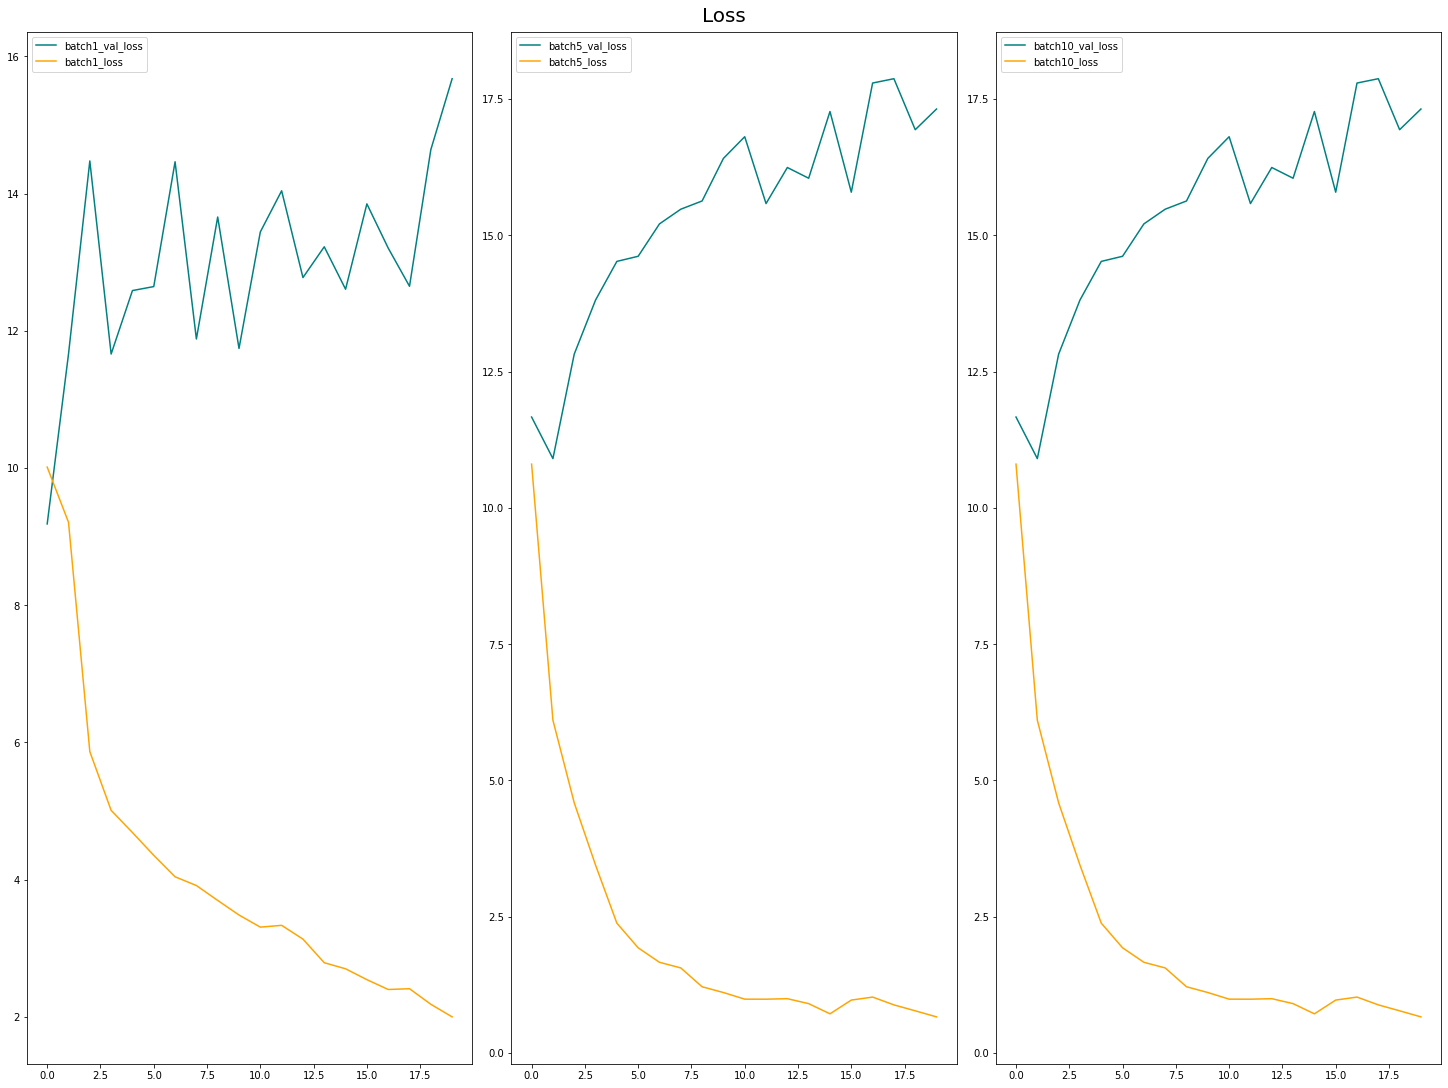

In [16]:
plt.rcParams['figure.figsize'] = [20, 15]
fig, axs = plt.subplots(1,3, constrained_layout = True)

axs[0].plot(resnet18_model.results['batch_1'].history['val_loss'], color='teal', label='batch1_val_loss')
axs[0].plot(resnet18_model.results['batch_1'].history['loss'], color='orange', label='batch1_loss')
axs[0].legend(loc='upper left')

axs[1].plot(resnet18_model.results['batch_5'].history['val_loss'], color='teal', label='batch5_val_loss')
axs[1].plot(resnet18_model.results['batch_5'].history['loss'], color='orange', label='batch5_loss')
axs[1].legend(loc='upper left')

axs[2].plot(resnet18_model.results['batch_5'].history['val_loss'], color='teal', label='batch10_val_loss')
axs[2].plot(resnet18_model.results['batch_5'].history['loss'], color='orange', label='batch10_loss')
axs[2].legend(loc='upper left')

fig.suptitle('Loss', fontsize=20)

plt.show()

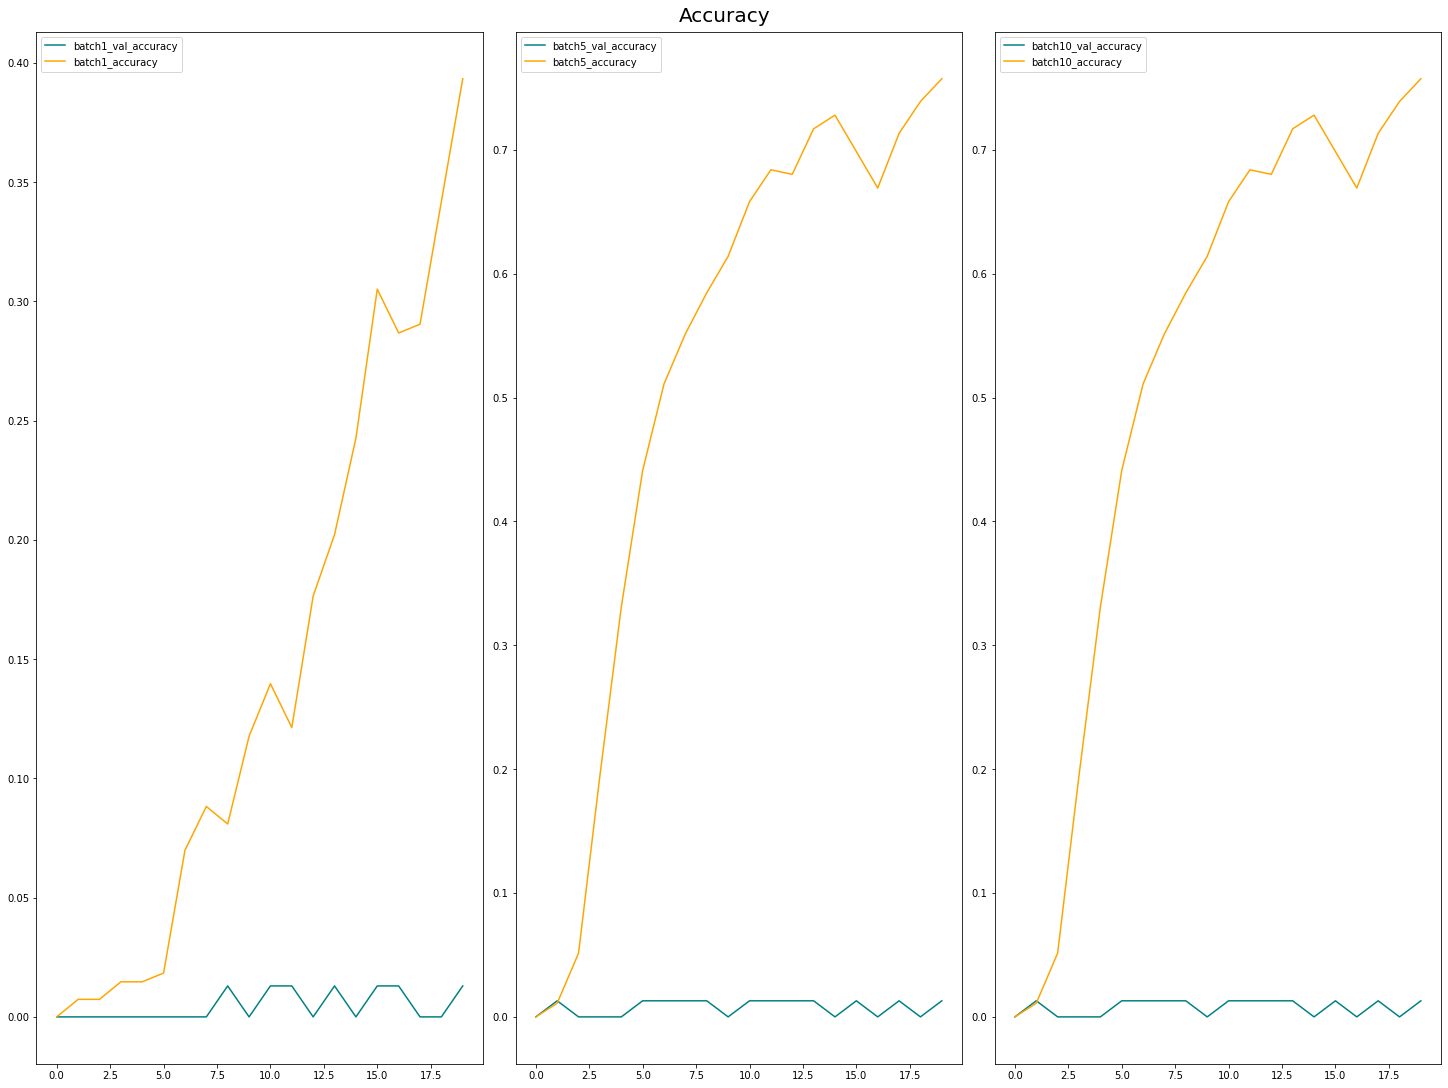

In [17]:
fig, axs = plt.subplots(1, 3, constrained_layout = True)

axs[0].plot(resnet18_model.results['batch_1'].history['val_accuracy'], color='teal', label='batch1_val_accuracy')
axs[0].plot(resnet18_model.results['batch_1'].history['accuracy'], color='orange', label='batch1_accuracy')
axs[0].legend(loc='upper left')

axs[1].plot(resnet18_model.results['batch_5'].history['val_accuracy'], color='teal', label='batch5_val_accuracy')
axs[1].plot(resnet18_model.results['batch_5'].history['accuracy'], color='orange', label='batch5_accuracy')
axs[1].legend(loc='upper left')

axs[2].plot(resnet18_model.results['batch_5'].history['val_accuracy'], color='teal', label='batch10_val_accuracy')
axs[2].plot(resnet18_model.results['batch_5'].history['accuracy'], color='orange', label='batch10_accuracy')
axs[2].legend(loc='upper left')

fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

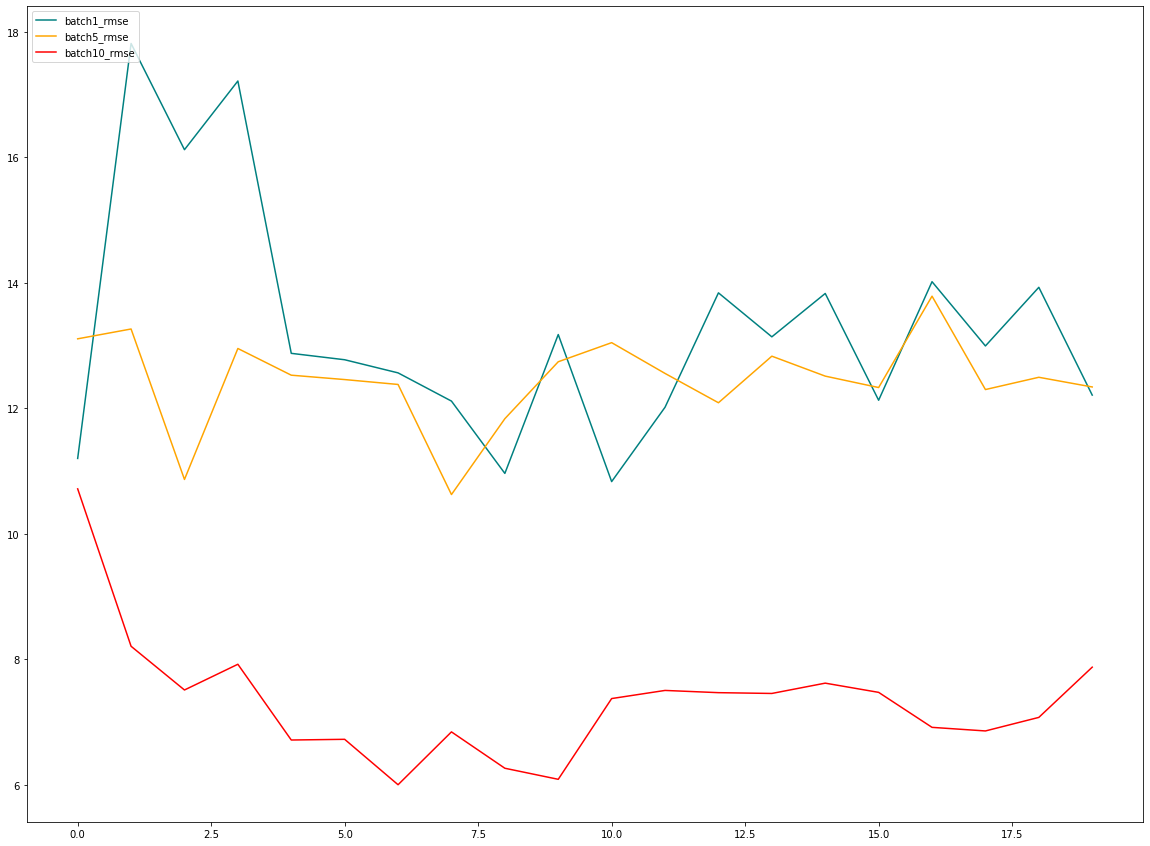

In [18]:
plt.plot(resnet18_model.results['batch_1'].history['rmse'], color='teal', label='batch1_rmse')
plt.plot(resnet18_model.results['batch_5'].history['rmse'], color='orange', label='batch5_rmse')
plt.plot(resnet18_model.results['batch_10'].history['rmse'], color='red', label='batch10_rmse')
plt.legend(loc='upper left')
plt.show()

Same as above, but this time with K Fold Cross Validation

In [23]:
class ValidationCallback(tf.keras.callbacks.Callback):
    
    def __init__(self, X_val, Y_val):
        super(ValidationCallback,self).__init__()
        self.X_val = X_val
        self.Y_val = Y_val
        
    # number_of_iterations = total_number_of_training_examples / batch_size
    # In this case, train example of 1,000 and batch size of 100
    # number_of_iterations over 1 epoch is 10
    # if have 5 epochs, number of iterations is 50
    
    def calc_error(self, actual, predicted):

        x_error = (actual[0] - predicted[0])**2
        y_error = (actual[1] - predicted[1])**2
        z_error = (actual[2] - predicted[2])**2

        return x_error + y_error + z_error
        
    # Have one function that reports metrics on end of every epoch
    def on_epoch_end(self, epoch, logs = None):
        
        # Get evaluation metrics
        print('\n')
        print('Epoch End - Custom Validation Callback')
        val_loss, val_accuracy = self.model.evaluate(self.X_val, self.Y_val, verbose = 0)
        
        # Get distance error metrics - RMSE
        # Get predictions for each feature heatmap in X_val
        Y_pred = self.model.predict(self.X_val, verbose = 0)
        err_sum = 0
        
        # Iterate through actual and predicted to get distance error
        for i in range(len(self.X_val)):

            # Get the coordinates for actual y
            actual_coords = rp_dict[self.Y_val[i][0]]
            
            # Get the coordinates for predicted y
            predicted_rp = np.argmax(Y_pred[i])
            pred_coords = rp_dict[predicted_rp]

            # Calculate distance error
            err = self.calc_error(actual_coords, pred_coords)
            err_sum += err
            
        # Get RMSE
        rmse = np.sqrt((err_sum/len(self.X_val)))
        # print(f'RMSE: {rmse}')
        logs['val_loss'] = val_loss
        logs['val_accuracy'] = val_accuracy
        logs['rmse'] = rmse

In [25]:
# What we have so far
from sklearn.model_selection import KFold

# print(features_transposed.shape)
# print(labels.shape)

# Get the images and labels for train and validation test set
train_features = np.array(list(train_dataset.map(lambda x,y : x)))
train_labels = np.array(list(train_dataset.map(lambda x,y : y)))

val_features = np.array(list(val_dataset.map(lambda x,y : x)))
val_labels = np.array(list(val_dataset.map(lambda x,y : y)))

# Split the data using K Fold algorithm
inputs = np.concatenate((train_features, val_features), axis = 0)
targets = np.concatenate((train_labels, val_labels), axis = 0)
kfold = KFold(n_splits = 10, shuffle = True)

# For each of the train, test
split_no = 1
results = {}

for train, val in kfold.split(inputs, targets):
    
    # Make model
    print(f'Processing split {split_no}')
    
    split_results = {}
    model_inputs = keras.Input(shape = (193, 16, 1))
    model_outputs = resnet18(model_inputs, num_classes = 3876)
    resnet18_model = keras.Model(model_inputs, model_outputs)
    
    # Compile model - Classification
    resnet18_model.compile(optimizer='adam',
          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
          metrics=['accuracy'])
    
    # Get the metrics
    val_callback = ValidationCallback(inputs[val], targets[val])
    hist = resnet18_model.fit(inputs[train], targets[train], batch_size = 32, callbacks = [val_callback], epochs = 20)
    split_results['loss'] = hist.history['loss']
    split_results['accuracy'] = hist.history['accuracy']
    split_results['val_loss'] = hist.history['val_loss']
    split_results['val_accuracy'] = hist.history['val_accuracy']
    split_results['rmse'] = hist.history['rmse']
    
    cur_split = 'split_' + str(split_no)
    results[cur_split] = split_results

    split_no += 1

print('All splits processed.')

Processing split 1
Epoch 1/20


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


99/99 [==============================] - ETA: 0s - loss: 9.1844 - accuracy: 0.0000e+00

Epoch End - Custom Validation Callback
99/99 [==============================] - 4s 22ms/step - loss: 9.1844 - accuracy: 0.0000e+00 - val_loss: 8.2629 - val_accuracy: 0.0000e+00 - rmse: 10.1955
Epoch 2/20
96/99 [============================>.] - ETA: 0s - loss: 8.2041 - accuracy: 0.0000e+00

Epoch End - Custom Validation Callback
99/99 [==============================] - 1s 13ms/step - loss: 8.2038 - accuracy: 0.0000e+00 - val_loss: 9.1757 - val_accuracy: 0.0000e+00 - rmse: 10.9339
Epoch 3/20
96/99 [============================>.] - ETA: 0s - loss: 8.0617 - accuracy: 3.2552e-04

Epoch End - Custom Validation Callback
99/99 [==============================] - 1s 13ms/step - loss: 8.0630 - accuracy: 3.1857e-04 - val_loss: 9.5291 - val_accuracy: 0.0000e+00 - rmse: 12.3253
Epoch 4/20
96/99 [============================>.] - ETA: 0s - loss: 7.9713 - accuracy: 3.2552e-04

Epoch End - Custom Validation Callba

<Figure size 1440x720 with 0 Axes>

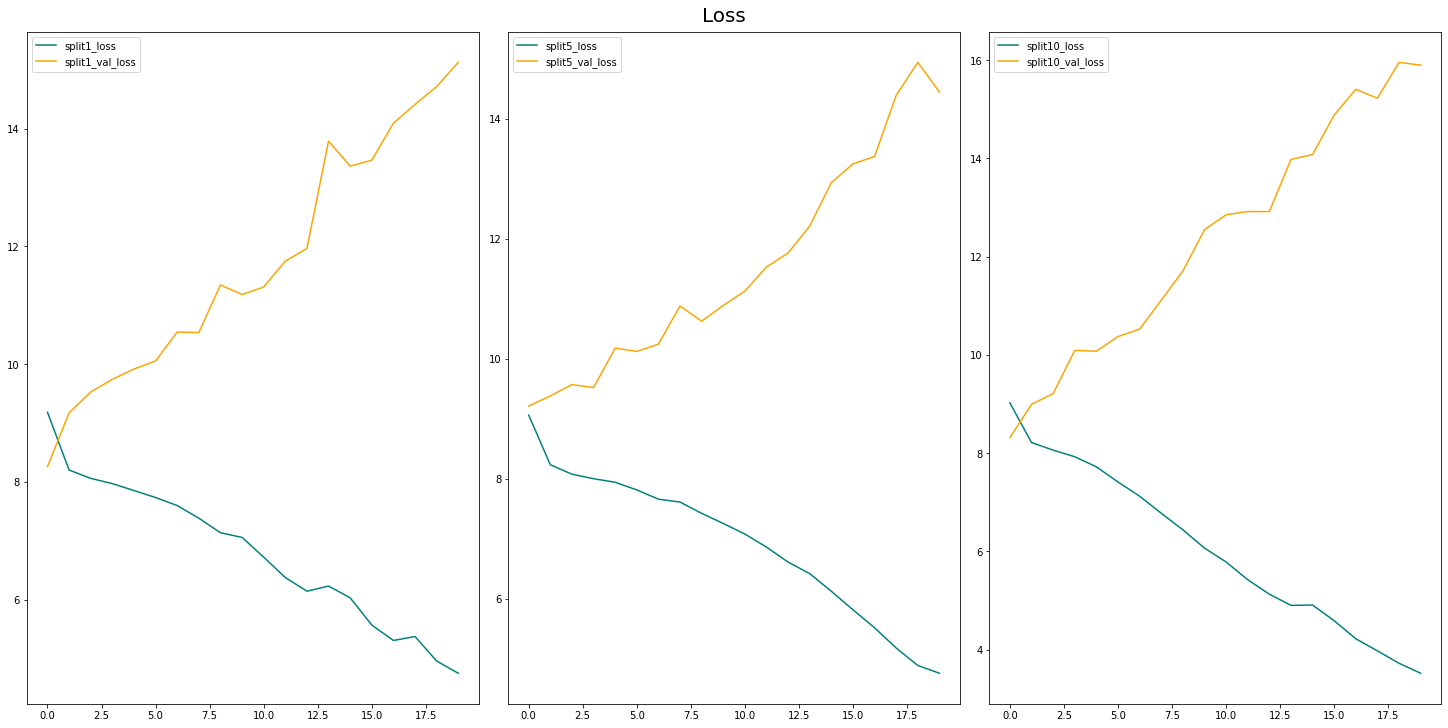

In [26]:
plt.rcParams['figure.figsize'] = [20, 10]
figure = plt.figure(figsize=(20,10))
fig, axs = plt.subplots(1,3, constrained_layout = True)

axs[0].plot(results['split_1']['loss'], color='teal', label='split1_loss')
axs[0].plot(results['split_1']['val_loss'], color='orange', label='split1_val_loss')
axs[0].legend(loc='upper left')

axs[1].plot(results['split_5']['loss'], color='teal', label='split5_loss')
axs[1].plot(results['split_5']['val_loss'], color='orange', label='split5_val_loss')
axs[1].legend(loc='upper left')

axs[2].plot(results['split_10']['loss'], color='teal', label='split10_loss')
axs[2].plot(results['split_10']['val_loss'], color='orange', label='split10_val_loss')
axs[2].legend(loc='upper left')

fig.suptitle('Loss', fontsize=20)

plt.show()

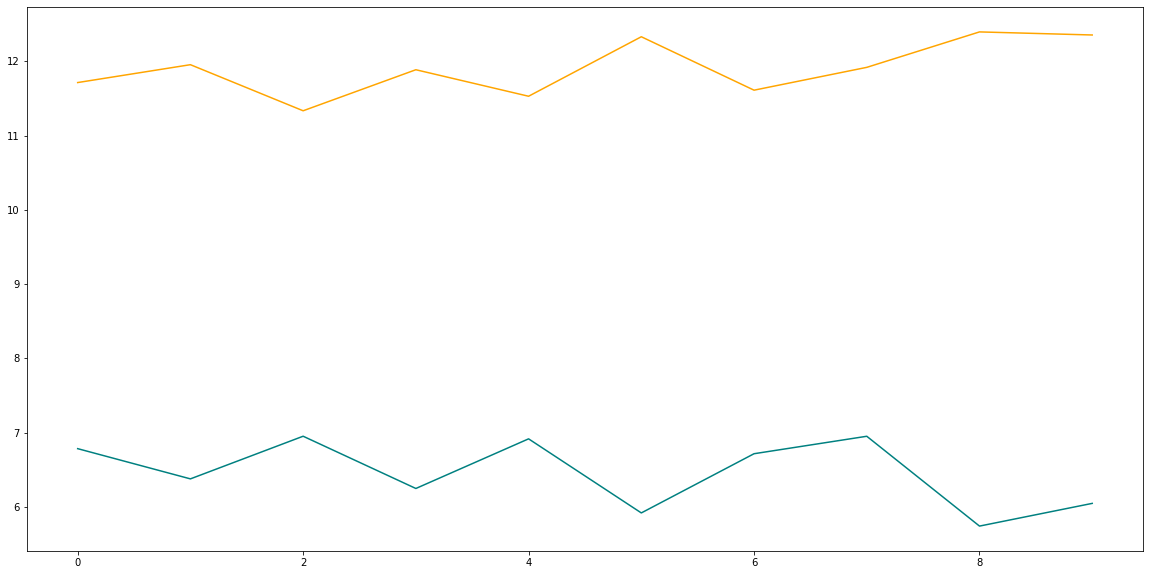

In [27]:
trg_loss = []
val_loss = []

for keys, values in results.items():

    trg_loss_avg = sum(results[keys]['loss'])/len(results[keys]['loss'])
    val_loss_avg = sum(results[keys]['val_loss'])/len(results[keys]['val_loss'])
    trg_loss.append(trg_loss_avg)
    val_loss.append(val_loss_avg)

plt.rcParams['figure.figsize'] = [20, 10]
figure = plt.figure(figsize=(20,10))

plt.plot(trg_loss, color='teal', label='trg_loss')
plt.plot(val_loss, color='orange', label='val_loss')

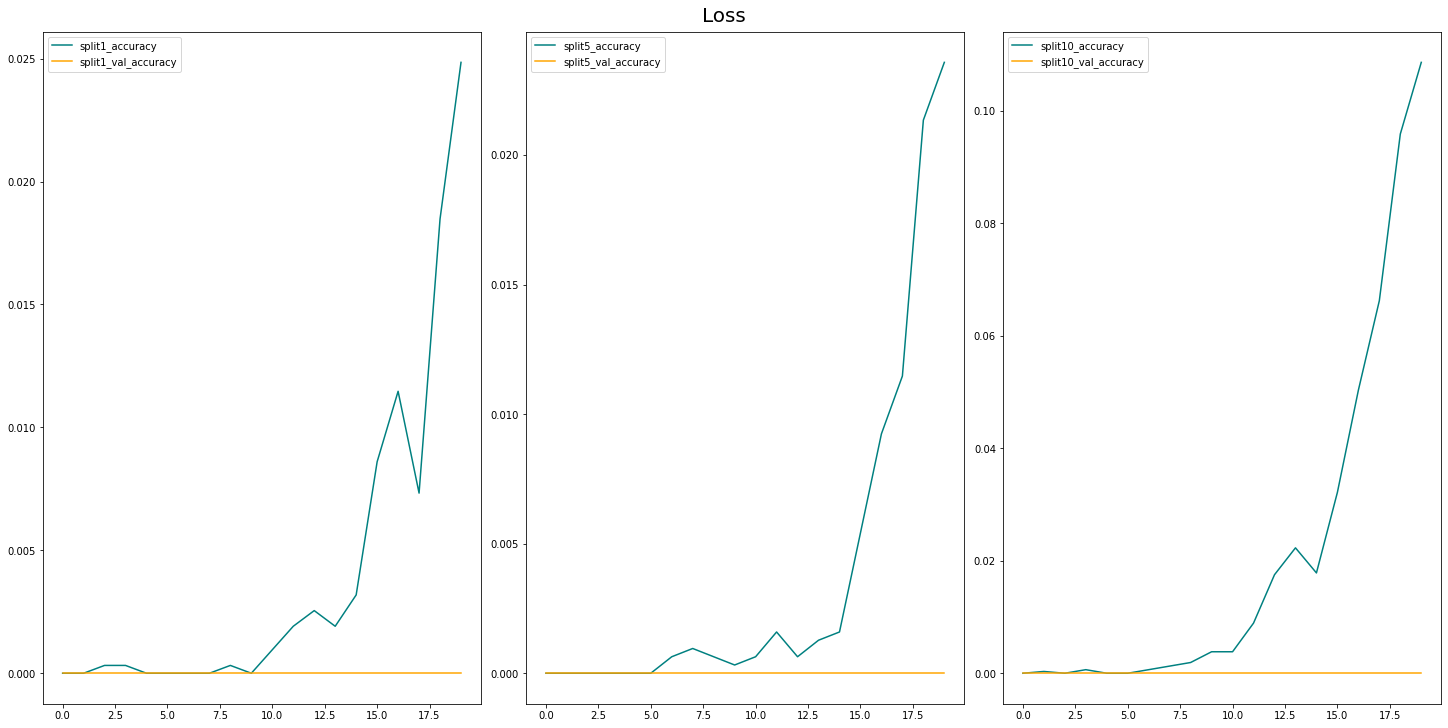

In [28]:
fig, axs = plt.subplots(1,3, constrained_layout = True)

axs[0].plot(results['split_1']['accuracy'], color='teal', label='split1_accuracy')
axs[0].plot(results['split_1']['val_accuracy'], color='orange', label='split1_val_accuracy')
axs[0].legend(loc='upper left')

axs[1].plot(results['split_5']['accuracy'], color='teal', label='split5_accuracy')
axs[1].plot(results['split_5']['val_accuracy'], color='orange', label='split5_val_accuracy')
axs[1].legend(loc='upper left')

axs[2].plot(results['split_10']['accuracy'], color='teal', label='split10_accuracy')
axs[2].plot(results['split_10']['val_accuracy'], color='orange', label='split10_val_accuracy')
axs[2].legend(loc='upper left')

fig.suptitle('Loss', fontsize=20)

plt.show()

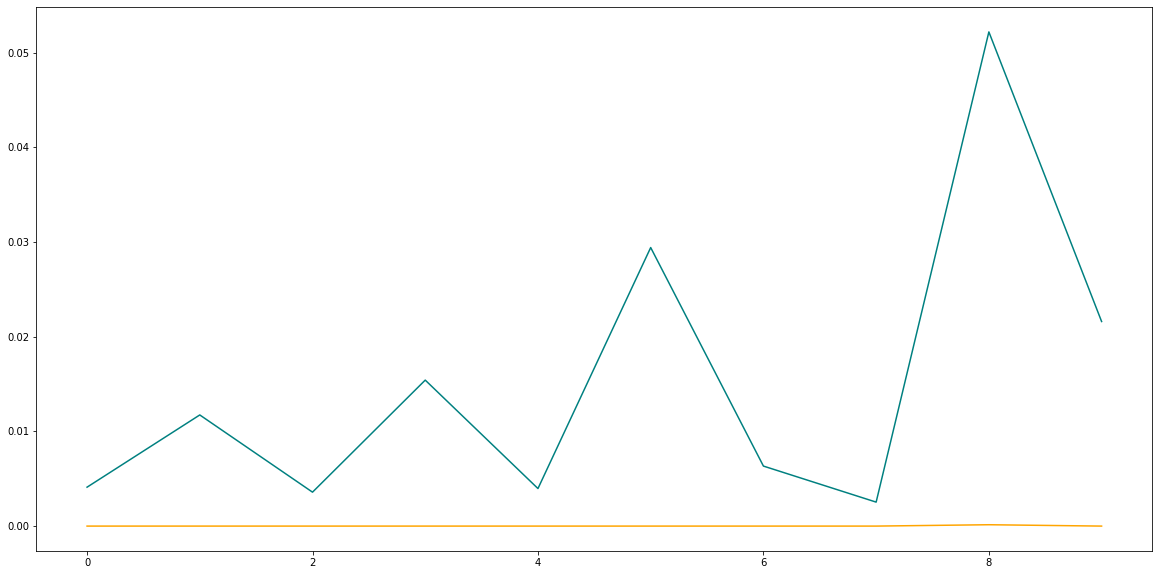

In [29]:
trg_acc = []
val_acc = []

for keys, values in results.items():

    acc_avg = sum(results[keys]['accuracy'])/len(results[keys]['accuracy'])
    val_acc_avg = sum(results[keys]['val_accuracy'])/len(results[keys]['val_accuracy'])
    trg_acc.append(acc_avg)
    val_acc.append(val_acc_avg)

plt.rcParams['figure.figsize'] = [20, 10]
figure = plt.figure(figsize=(20,10))

plt.plot(trg_acc, color='teal', label='trg_acc')
plt.plot(val_acc, color='orange', label='val_acc')

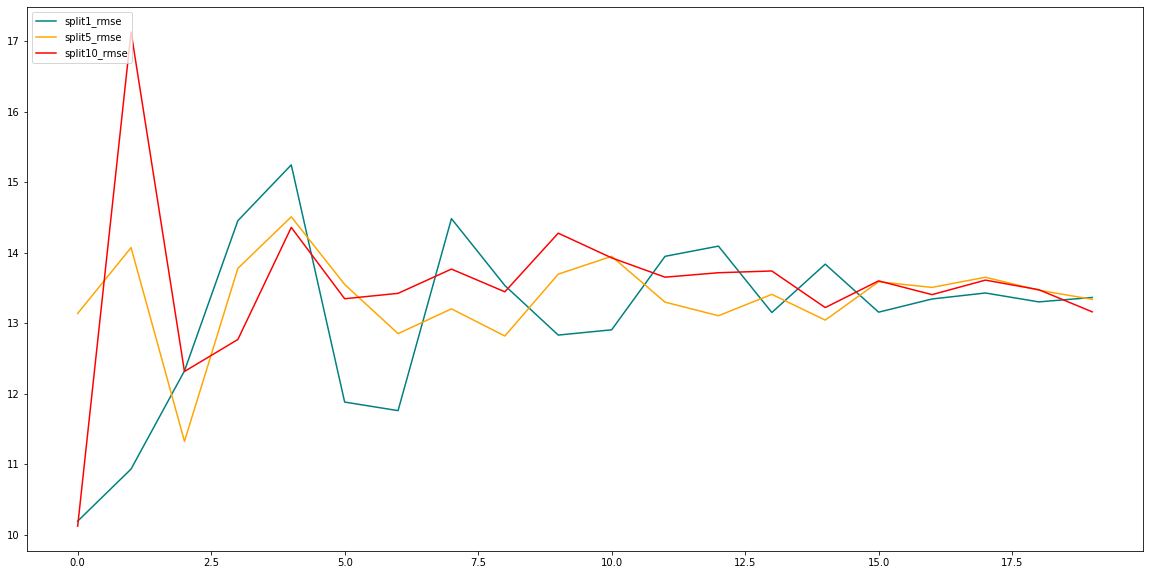

In [30]:
plt.plot(results['split_1']['rmse'], color='teal', label='split1_rmse')
plt.plot(results['split_5']['rmse'], color='orange', label='split5_rmse')
plt.plot(results['split_10']['rmse'], color='red', label='split10_rmse')
plt.legend(loc='upper left')
plt.show()

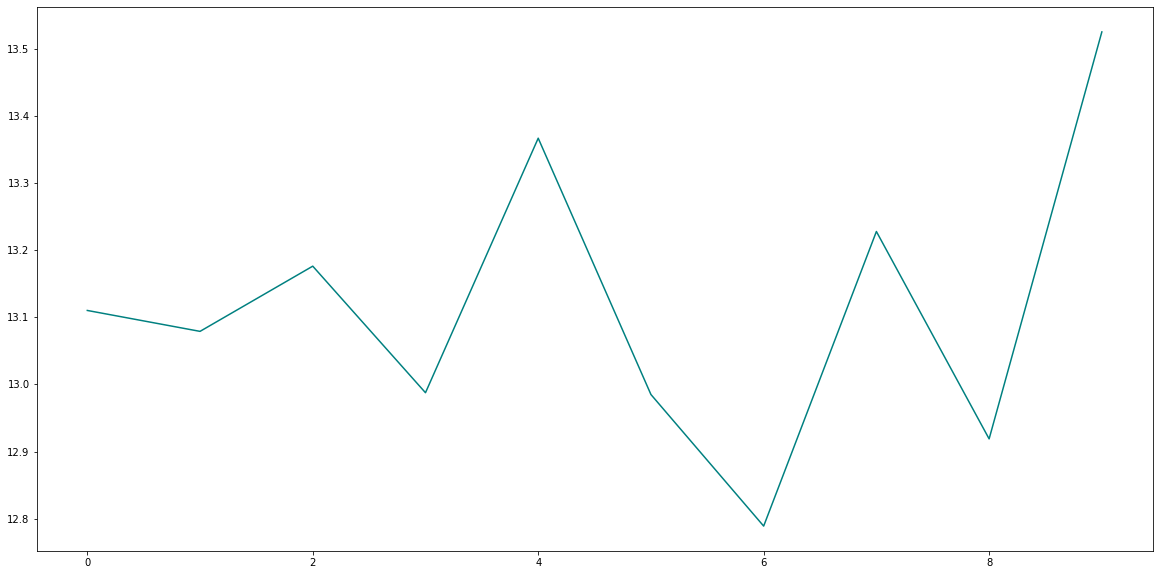

In [32]:
val_rmse = []

for keys, values in results.items():

    val_rmse_avg = sum(results[keys]['rmse'])/len(results[keys]['rmse'])
    val_rmse.append(val_rmse_avg)

plt.rcParams['figure.figsize'] = [20, 10]
figure = plt.figure(figsize=(20,10))

plt.plot(val_rmse, color='teal', label='rmse')

## Analysis of results

- Severe case of overfitting
- Possible solutions:
    - Model performs well on train but poorly on validation
    - Perform data augmentation
        - For each image in each outdoor dataset,
            1. Gaussian Noise
            2. Rotation
        - Image similarities to be benchmarked using SSIM value
    - Dropout layers and regularisation in convolution layers

In [9]:
'''
Parameters
----------
image : ndarray
    Input image data. Will be converted to float.
mode : str
    One of the following strings, selecting the type of noise to add:

    'gauss'     Gaussian-distributed additive noise.
    'poisson'   Poisson-distributed noise generated from the data.
    's&p'       Replaces random pixels with 0 or 1.
    'speckle'   Multiplicative noise using out = image + n*image,where
                n is uniform noise with specified mean & variance.
'''

import numpy as np

def noisy(noise_typ,image):
    
    if noise_typ == "gauss":
        row,col,ch= image.shape
        mean = 0
        var = 0.1
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(row,col,ch))
        gauss = gauss.reshape(row,col,ch)
        noisy = image + gauss
        return noisy
    
    elif noise_typ == "s&p":
        row,col,ch = image.shape
        s_vs_p = 0.5
        amount = 0.004
        out = np.copy(image)
        
        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
        out[coords] = 1

        # Pepper mode
        num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape]
        out[coords] = 0
        return out
        
    elif noise_typ == "poisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
        return noisy
    
    elif noise_typ =="speckle":
        row,col,ch = image.shape
        gauss = np.random.randn(row,col,ch)
        gauss = gauss.reshape(row,col,ch)        
        noisy = image + image * gauss
        return noisy

In [10]:
# Note: Every colummn refers to measurements from same frequency channel, at different time intervals
# Add noise according to the mean and std of values along the column
def add_gaussian_noise(feature):
    
    num_rows, num_cols = feature.shape[0], feature.shape[1]
    noisy = feature.copy()
    
    # Iterate along the columns of each image
    for i in range(num_cols):
        
        # Get all values in that same column
        channel_values = feature[:,i]
        channel_std = np.std(channel_values)
        channel_mean = np.mean(channel_values)
        
        # Create normal distribution according to std of values with mean 0
        gauss = np.random.normal(0, 1.5 * channel_std, (num_rows))
        noisy[:,i] = feature[:,i] + gauss
        
    feature = np.expand_dims(feature, axis = 2)
    noisy = np.expand_dims(noisy, axis = 2)

    ssim_value = tf.image.ssim(feature, noisy, max_val=1.0, filter_size=11,
                      filter_sigma=1.5, k1=0.01, k2=0.03).numpy()

    # plt.imshow(noisy, aspect = 'auto')
    return (ssim_value, noisy)

In [13]:
# This function takes in dataset in the numpy format
import h5py
import numpy as np
import tensorflow as tf

def augment_ds(filename):
    
    # Open HDF5 file and access the dataset

    hdf5_file = h5py.File(filename, 'r')

    features_dataset = hdf5_file['features']
    labels_dataset = hdf5_file['labels']['position']

    # Convert HDF5 dataset to NumPy array
    features = np.array(features_dataset)
    labels = np.array(labels_dataset)

    # Prepare features for dataset
    # Retrieve features from the first UE and transpose the individual matrix
    features_transposed = np.zeros((3876,193,16), dtype = np.float64)
    for i in range(len(features)):
        features_transposed[i] = features[i][0].T

    # Prepare labels for dataset
    count = 0
    rp_dict = {}
    # For labels, have a shape of (1,) where that number represents the class of that coordinate

    for label in labels:
        rp_dict[count] = label
        count += 1

    labels = np.array([i for i in range(3876)])

    # Close the HDF5 file
    hdf5_file.close()

    # Currently, for features, have features from 3876 reference points, from 4 UEs, for (16,193) matrices
    print(features_transposed.shape)
    print(labels.shape)
   
    generated_features = []
    generated_coords = []
    
    # Iterate through each feature
    for index, feature in enumerate(features_transposed):
            
        generated_count = 0
        attempts = 0
        
        # while 5 noisy images have not been generated yet,
        while generated_count < 5:
            
            if attempts > 20:
                print(f'Unable to generate data. Index: {index}')
                break
                
            similarity_val, noisy_img = add_gaussian_noise(feature)
            
            # if images are not similar enough,
            if similarity_val >= 0.5:
                generated_features.append(noisy_img)
                generated_coords.append(index)
                generated_count += 1
            
            attempts += 1
            
    print("Finish augmenting")
    np_generated_features = np.array(generated_features)
    np_generated_features = np.squeeze(np_generated_features, axis=(3,))
    np_generated_coords = np.array(generated_coords)
   
    print("Finish making numpy arrays")

    all_features = np.concatenate((features_transposed, np_generated_features), axis = 0)
    all_coords = np.concatenate((labels, np_generated_coords), axis = 0)
    
    print("Finish concatenating numpy arrays")

    return all_features, all_coords

In [14]:
# filename = 'dataset_SNR20_outdoor.mat'
features_snr10, coords_snr10 = augment_ds('dataset_SNR10_outdoor.mat')
print(features_snr10.shape, coords_snr10.shape)

(3876, 193, 16)
(3876,)
Unable to generate data. Index: 332
Unable to generate data. Index: 362
Unable to generate data. Index: 397
Unable to generate data. Index: 405
Unable to generate data. Index: 431
Unable to generate data. Index: 473
Unable to generate data. Index: 499
Unable to generate data. Index: 501
Unable to generate data. Index: 506
Unable to generate data. Index: 508
Unable to generate data. Index: 532
Unable to generate data. Index: 538
Unable to generate data. Index: 539
Unable to generate data. Index: 559
Unable to generate data. Index: 563
Unable to generate data. Index: 576
Unable to generate data. Index: 600
Unable to generate data. Index: 606
Unable to generate data. Index: 2107
Unable to generate data. Index: 2277
Unable to generate data. Index: 3673
Unable to generate data. Index: 3825
Unable to generate data. Index: 3861
Finish augmenting
Finish making numpy arrays
FInish concatenating numpy arrays
(23170, 193, 16) (23170,)


In [15]:
features_snr20, coords_snr20 = augment_ds('dataset_SNR20_outdoor.mat')
print(features_snr20.shape, coords_snr20.shape)

(3876, 193, 16)
(3876,)
Unable to generate data. Index: 266
Unable to generate data. Index: 332
Unable to generate data. Index: 362
Unable to generate data. Index: 397
Unable to generate data. Index: 405
Unable to generate data. Index: 431
Unable to generate data. Index: 436
Unable to generate data. Index: 473
Unable to generate data. Index: 499
Unable to generate data. Index: 501
Unable to generate data. Index: 506
Unable to generate data. Index: 508
Unable to generate data. Index: 532
Unable to generate data. Index: 537
Unable to generate data. Index: 538
Unable to generate data. Index: 539
Unable to generate data. Index: 559
Unable to generate data. Index: 563
Unable to generate data. Index: 574
Unable to generate data. Index: 576
Unable to generate data. Index: 600
Unable to generate data. Index: 2004
Unable to generate data. Index: 2107
Unable to generate data. Index: 2276
Unable to generate data. Index: 3673
Finish augmenting
Finish making numpy arrays
FInish concatenating numpy 

In [16]:
features_snr50, coords_snr50 = augment_ds('dataset_SNR50_outdoor.mat')
print(features_snr50.shape, coords_snr50.shape)

(3876, 193, 16)
(3876,)
Unable to generate data. Index: 266
Unable to generate data. Index: 332
Unable to generate data. Index: 362
Unable to generate data. Index: 397
Unable to generate data. Index: 405
Unable to generate data. Index: 431
Unable to generate data. Index: 436
Unable to generate data. Index: 473
Unable to generate data. Index: 499
Unable to generate data. Index: 501
Unable to generate data. Index: 506
Unable to generate data. Index: 508
Unable to generate data. Index: 532
Unable to generate data. Index: 537
Unable to generate data. Index: 538
Unable to generate data. Index: 539
Unable to generate data. Index: 559
Unable to generate data. Index: 563
Unable to generate data. Index: 574
Unable to generate data. Index: 576
Unable to generate data. Index: 600
Unable to generate data. Index: 2004
Unable to generate data. Index: 2276
Unable to generate data. Index: 3673
Unable to generate data. Index: 3861
Finish augmenting
Finish making numpy arrays
FInish concatenating numpy 

In [17]:
# Double confirm correctness
print(coords_snr50.shape)
unique_coords = set(list(coords_snr50))
print(f'No. of unique coordinates are: {len(unique_coords)}')

(23147,)
No. of unique coordinates are: 3876


In [18]:
features = np.concatenate((features_snr10, features_snr20, features_snr50), axis = 0)
labels = np.concatenate((coords_snr10, coords_snr20, coords_snr50), axis = 0)

In [19]:
# Confirm shapes to confirm correctness
print(features.shape, labels.shape)

# Save data into numpy files
np.save('augmented_features_ds', features)
np.save('augmented_labels_ds', labels)

(69472, 193, 16) (69472,)


## Overfitting Solution 1: Trial with augmented datasets

### Augmented Dataset 1: 
- 5 noisy samples created with Gaussian noise, with reference to SNR at 10, 20 and 50.
- SSIM threshold = **0.5**
- Gaussian distribution: mean = **0**, std = **1.5* channel_std**

In [13]:
# Necessary imports
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
# Get dictionary of RP index and coordinates

# Open HDF5 file and access the dataset
filename = 'dataset_SNR10_outdoor.mat'
hdf5_file = h5py.File(filename, 'r')

features_dataset = hdf5_file['features']
labels_dataset = hdf5_file['labels']['position']

# Convert HDF5 dataset to NumPy array
features = np.array(features_dataset)
labels = np.array(labels_dataset)

# Prepare features for dataset
# Retrieve features from the first UE and transpose the individual matrix
features_transposed = np.zeros((3876,193,16), dtype = np.float64)
for i in range(len(features)):
    features_transposed[i] = features[i][0].T

# Prepare labels for dataset
count = 0
rp_dict = {}
# For labels, have a shape of (1,) where that number represents the class of that coordinate

for label in labels:
    rp_dict[count] = label
    count += 1

# Close the HDF5 file
hdf5_file.close()

In [4]:
# Import dataset

features = np.load('augmented_features_ds.npy')
labels = np.load('augmented_labels_ds.npy')

print(f'Shape of features np array: {features.shape}')
print(f'Shape of labels np array: {labels.shape}')

Shape of features np array: (69472, 193, 16)
Shape of labels np array: (69472,)


In [5]:
dataset = tf.data.Dataset.from_tensor_slices((features, labels))
dataset = dataset.map(lambda x,y : (x, tf.expand_dims(y, axis = 0)))

2023-06-09 01:40:20.193723: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-09 01:40:20.654157: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43428 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:61:00.0, compute capability: 8.6


In [6]:
# Numeric argument refers to size of buffer used in shuffling. Larger buffer size results in more thorough shuffling but requires more memory
dataset = dataset.shuffle(1000)
# reshuffle_each_iteration = False

In [7]:
# Split the dataset into train, test and validaiton set
def split_dataset(ds):
    size = len(ds)
    train_size = int(round(size*0.7))
    val_size = int(round(size*0.2))
    test_size = int(round(size*0.1))
          
    train_dataset = ds.take(train_size)
    val_dataset = ds.skip(train_size).take(val_size)
    test_dataset = ds.skip(train_size + val_size).take(test_size)

    return train_dataset, val_dataset, test_dataset

train_dataset, val_dataset, test_dataset = split_dataset(dataset)

In [13]:
# Create custom callbacks to evaluate model
class ValidationCallback(tf.keras.callbacks.Callback):
    
    def __init__(self, X_val, Y_val):
        super(ValidationCallback,self).__init__()
        self.X_val = X_val
        self.Y_val = Y_val
        
    # number_of_iterations = total_number_of_training_examples / batch_size
    # In this case, train example of 1,000 and batch size of 100
    # number_of_iterations over 1 epoch is 10
    # if have 5 epochs, number of iterations is 50
    
    def calc_error(self, actual, predicted):

        x_error = (actual[0] - predicted[0])**2
        y_error = (actual[1] - predicted[1])**2
        z_error = (actual[2] - predicted[2])**2

        return x_error + y_error + z_error
        
    # Have one function that reports metrics on end of every epoch
    def on_epoch_end(self, epoch, logs = None):
        
        # Get evaluation metrics
        print('\n')
        print('Epoch End - Custom Validation Callback')
        # val_loss, val_accuracy = self.model.evaluate(self.X_val, self.Y_val, verbose = 0)
        
        # Get distance error metrics - RMSE
        # Get predictions for each feature heatmap in X_val
        Y_pred = self.model.predict(self.X_val, verbose = 0)
        err_sum = 0
        
        # Iterate through actual and predicted to get distance error
        for i in range(len(self.X_val)):

            # Get the coordinates for actual y
            actual_coords = rp_dict[self.Y_val[i][0]]
            
            # Get the coordinates for predicted y
            predicted_rp = np.argmax(Y_pred[i])
            pred_coords = rp_dict[predicted_rp]

            # Calculate distance error
            err = self.calc_error(actual_coords, pred_coords)
            err_sum += err
            
        # Get RMSE
        rmse = np.sqrt((err_sum/len(self.X_val)))
        # print(f'RMSE: {rmse}')
        # logs['val_loss'] = val_loss
        # logs['val_accuracy'] = val_accuracy
        logs['rmse'] = rmse

In [14]:
from sklearn.model_selection import KFold
from resnet import resnet18

import time

# print(features_transposed.shape)
# print(labels.shape)

# Get the images and labels for train and validation test set
train_features = np.array(list(train_dataset.map(lambda x,y : x)))
train_labels = np.array(list(train_dataset.map(lambda x,y : y)))

val_features = np.array(list(val_dataset.map(lambda x,y : x)))
val_labels = np.array(list(val_dataset.map(lambda x,y : y)))

# Split the data using K Fold algorithm
inputs = np.concatenate((train_features, val_features), axis = 0)
targets = np.concatenate((train_labels, val_labels), axis = 0)
kfold = KFold(n_splits = 5, shuffle = True)

# For each of the train, test
split_no = 1
results = {}

# Perform K Fold Validation
for train, val in kfold.split(inputs, targets):
    
    # Make model
    print(f'Processing split {split_no}')
    
    split_results = {}
    # Create model
    model_inputs = keras.Input(shape = (193, 16, 1))
    model_outputs = resnet18(model_inputs, num_classes = 3876)
    resnet18_model = keras.Model(model_inputs, model_outputs)

    # Compile model - Classification
    # default learning rate is 1e-3 = 0.001
    resnet18_model.compile(optimizer='adam',
          loss=tf.keras.losses.SparseCategoricalCrossentropy(),
          metrics=['accuracy'])

    # Get the metrics
    val_callback = ValidationCallback(inputs[val], targets[val])
    start_time = time.time()
    hist = resnet18_model.fit(inputs[train], targets[train], batch_size = 32, validation_data = (inputs[val], targets[val]),
                              callbacks = [val_callback], epochs = 100)
    print(hist)
    end_time = time.time()
    epoch_trgtime = end_time - start_time
    
    split_results['loss'] = hist.history['loss']
    split_results['accuracy'] = hist.history['accuracy']
    split_results['val_loss'] = hist.history['val_loss']
    split_results['val_accuracy'] = hist.history['val_accuracy']
    split_results['rmse'] = hist.history['rmse']
    split_results['train_time'] = epoch_trgtime
    
    cur_split = 'split_' + str(split_no)
    results[cur_split] = split_results

    split_no += 1

print('All splits processed.')

Processing split 1
Epoch 1/100
1562/1564 [============================>.] - ETA: 0s - loss: 8.2963 - accuracy: 3.8012e-04

Epoch End - Custom Validation Callback
1564/1564 [==============================] - 22s 13ms/step - loss: 8.2965 - accuracy: 3.7986e-04 - val_loss: 8.3705 - val_accuracy: 2.3990e-04 - rmse: 14.2666
Epoch 2/100
1561/1564 [============================>.] - ETA: 0s - loss: 8.0548 - accuracy: 4.8046e-04

Epoch End - Custom Validation Callback
1564/1564 [==============================] - 20s 13ms/step - loss: 8.0569 - accuracy: 4.7982e-04 - val_loss: 7.9990 - val_accuracy: 7.9968e-04 - rmse: 12.2962
Epoch 3/100
1562/1564 [============================>.] - ETA: 0s - loss: 7.9163 - accuracy: 4.8015e-04

Epoch End - Custom Validation Callback
1564/1564 [==============================] - 20s 13ms/step - loss: 7.9199 - accuracy: 4.7982e-04 - val_loss: 8.1024 - val_accuracy: 7.9968e-04 - rmse: 10.9584
Epoch 4/100
1560/1564 [============================>.] - ETA: 0s - loss: 7.

<Figure size 1440x720 with 0 Axes>

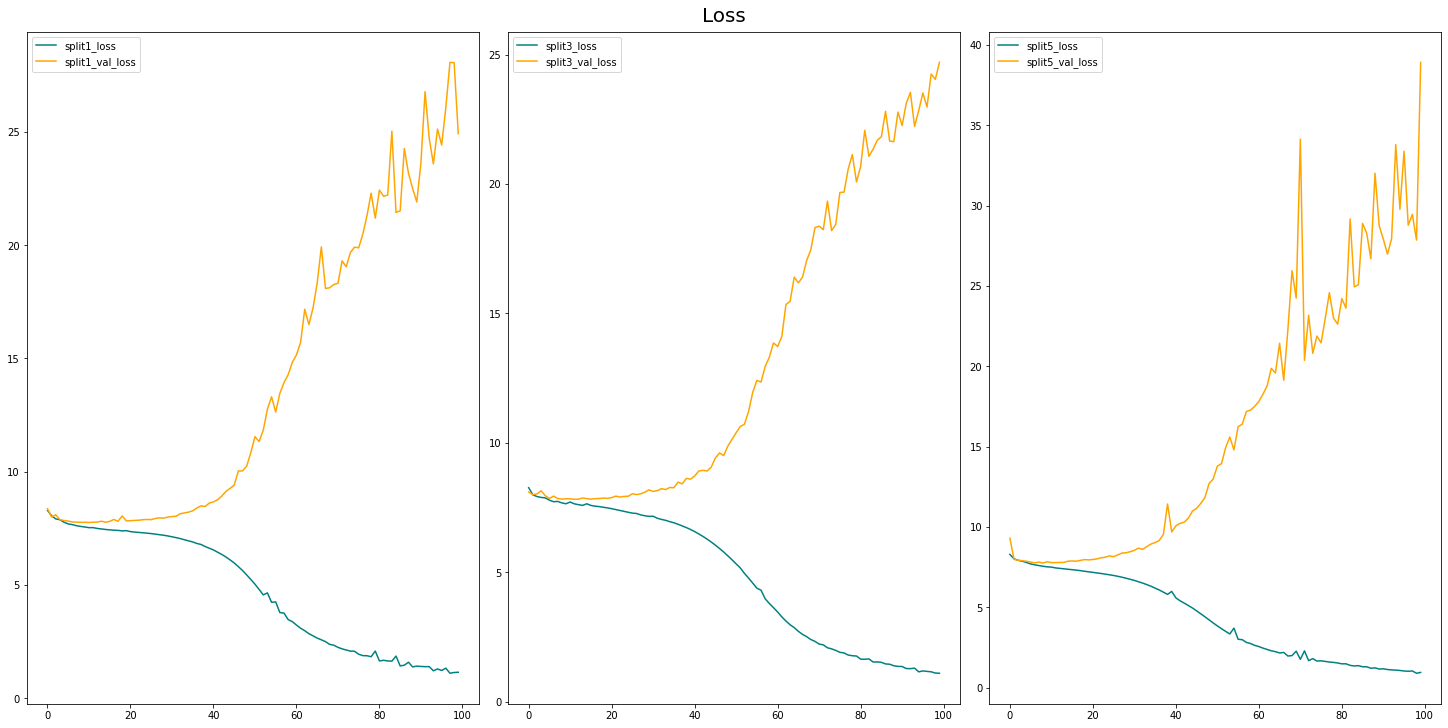

In [15]:
plt.rcParams['figure.figsize'] = [20, 10]
figure = plt.figure(figsize=(20,10))
fig, axs = plt.subplots(1,3, constrained_layout = True)

axs[0].plot(results['split_1']['loss'], color='teal', label='split1_loss')
axs[0].plot(results['split_1']['val_loss'], color='orange', label='split1_val_loss')
axs[0].legend(loc='upper left')

axs[1].plot(results['split_3']['loss'], color='teal', label='split3_loss')
axs[1].plot(results['split_3']['val_loss'], color='orange', label='split3_val_loss')
axs[1].legend(loc='upper left')

axs[2].plot(results['split_5']['loss'], color='teal', label='split5_loss')
axs[2].plot(results['split_5']['val_loss'], color='orange', label='split5_val_loss')
axs[2].legend(loc='upper left')

fig.suptitle('Loss', fontsize=20)

plt.show()

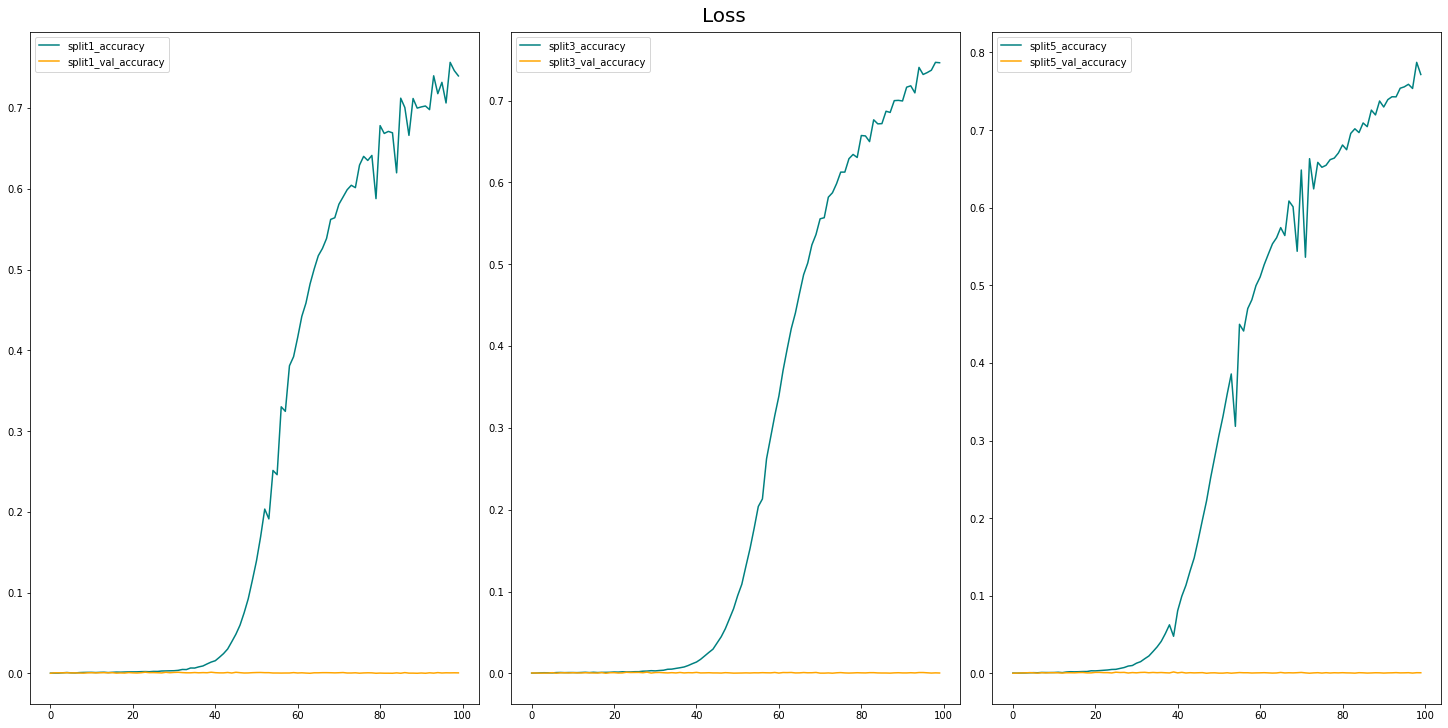

In [17]:
fig, axs = plt.subplots(1,3, constrained_layout = True)

axs[0].plot(results['split_1']['accuracy'], color='teal', label='split1_accuracy')
axs[0].plot(results['split_1']['val_accuracy'], color='orange', label='split1_val_accuracy')
axs[0].legend(loc='upper left')

axs[1].plot(results['split_3']['accuracy'], color='teal', label='split3_accuracy')
axs[1].plot(results['split_3']['val_accuracy'], color='orange', label='split3_val_accuracy')
axs[1].legend(loc='upper left')

axs[2].plot(results['split_5']['accuracy'], color='teal', label='split5_accuracy')
axs[2].plot(results['split_5']['val_accuracy'], color='orange', label='split5_val_accuracy')
axs[2].legend(loc='upper left')

fig.suptitle('Loss', fontsize=20)

plt.show()

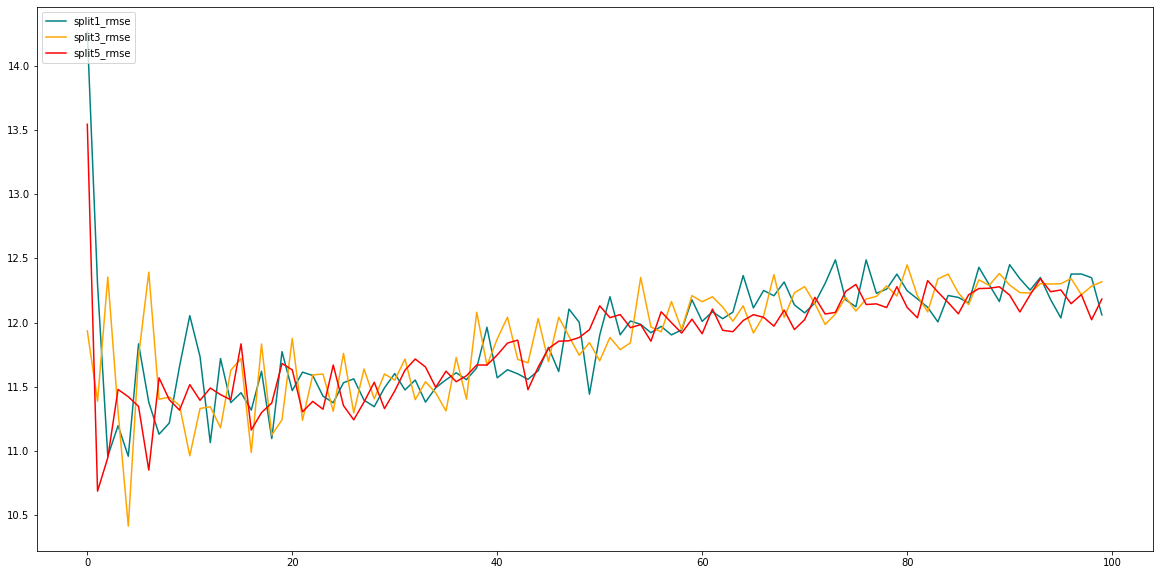

In [20]:
plt.plot(results['split_1']['rmse'], color='teal', label='split1_rmse')
plt.plot(results['split_3']['rmse'], color='orange', label='split3_rmse')
plt.plot(results['split_5']['rmse'], color='red', label='split5_rmse')
plt.legend(loc='upper left')
plt.show()

In [26]:
ttal_time = 0
num_splits = len(results)

for key, value in results.items():
    ttal_time += results[key]['train_time']

print(f'Average train time for 100 epochs: {round(ttal_time/num_splits,2)}s')

Average train time for 100 epochs: 1994.37s


### Observation:

Continual poor performance on validation set with training set able to fit - Overfitting

### Diagnosis 1: Check if the classes are balanced in train and validation dataset

In [36]:
# Split data into train and validation

train_features = np.array(list(train_dataset.map(lambda x,y : x)))
train_labels = np.array(list(train_dataset.map(lambda x,y : y)))

val_features = np.array(list(val_dataset.map(lambda x,y : x)))
val_labels = np.array(list(val_dataset.map(lambda x,y : y)))

# Split the data using K Fold algorithm
inputs = np.concatenate((train_features, val_features), axis = 0)
targets = np.concatenate((train_labels, val_labels), axis = 0)
kfold = KFold(n_splits = 5, shuffle = True)

# Perform K Fold Validation
split_no = 0
for train, val in kfold.split(inputs, targets):
    
    # For each fold, determine no. of unique classes in training and validation present
    Y_train = targets[train][:,0]
    Y_val = targets[val][:,0]
    
    print(f'Split {split_no}:')
    print(f'No. of unique classes in Y_train: {len(set(list(Y_train)))}')
    print(f'No. of unique classes in Y_val: {len(set(list(Y_val)))}')
    
    # Determine number of overlapping classes present
    common_classes = list(set(Y_train).intersection(Y_val))
    classes = [i for i in range(3876)]
    
    print(f'No. of common classes: {len(common_classes)}')
    
    excluded_classes = list(set(classes) - set(common_classes))
    print(f'Excluded classes: {excluded_classes}')
    
    split_no += 1    

Split 0:
No. of unique classes in Y_train: 3876
No. of unique classes in Y_val: 3758
No. of common classes: 3758
Excluded classes: [3591, 2574, 1041, 532, 3096, 538, 539, 2589, 1056, 3112, 2090, 45, 3637, 58, 2623, 576, 3652, 3149, 3154, 3580, 3677, 606, 3688, 3691, 2162, 3188, 2677, 124, 125, 3718, 2183, 2696, 3229, 1185, 2722, 1187, 676, 168, 3757, 3247, 2228, 191, 1727, 2751, 3265, 2255, 2773, 3799, 2778, 3290, 2787, 3311, 3825, 3315, 2805, 2297, 255, 3839, 259, 777, 266, 268, 270, 1295, 2834, 788, 1814, 3351, 792, 2841, 3354, 2331, 3868, 2333, 3362, 2862, 1839, 3374, 2872, 3384, 3401, 2387, 2901, 2402, 2403, 3426, 362, 2929, 2936, 3448, 2947, 1414, 2951, 1931, 2956, 397, 2444, 3477, 3479, 1433, 411, 3491, 3492, 3500, 1965, 1967, 1968, 3026, 2003, 2519, 2009, 3556, 492, 3057, 3059, 1524, 3065, 508]
Split 1:
No. of unique classes in Y_train: 3876
No. of unique classes in Y_val: 3751
No. of common classes: 3751
Excluded classes: [3585, 3591, 3596, 3602, 3092, 3093, 538, 543, 1567, 33,

### Augmented Dataset 2: 
- 10 noisy samples created with Gaussian noise, with reference to SNR at 10, 20 and 50.
- SSIM threshold = **0.5**
- Gaussian distribution: mean = **0**, std = **2 * channel_std**

In [1]:
# Note: Every colummn refers to measurements from same frequency channel, at different time intervals
# Add noise according to the mean and std of values along the column
def add_gaussian_noise(feature):
    
    num_rows, num_cols = feature.shape[0], feature.shape[1]
    noisy = feature.copy()
    
    # Iterate along the columns of each image
    for i in range(num_cols):
        
        # Get all values in that same column
        channel_values = feature[:,i]
        channel_std = np.std(channel_values)
        channel_mean = np.mean(channel_values)
        
        # Create normal distribution according to std of values with mean 0
        gauss = np.random.normal(0, 2 * channel_std, (num_rows))
        noisy[:,i] = feature[:,i] + gauss
        
    feature = np.expand_dims(feature, axis = 2)
    noisy = np.expand_dims(noisy, axis = 2)

    ssim_value = tf.image.ssim(feature, noisy, max_val=1.0, filter_size=11,
                      filter_sigma=1.5, k1=0.01, k2=0.03).numpy()

    # plt.imshow(noisy, aspect = 'auto')
    return (ssim_value, noisy)

In [2]:
# This function takes in dataset in the numpy format
import h5py
import numpy as np
import tensorflow as tf

def augment_ds(filename):
    
    # Open HDF5 file and access the dataset

    hdf5_file = h5py.File(filename, 'r')

    features_dataset = hdf5_file['features']
    labels_dataset = hdf5_file['labels']['position']

    # Convert HDF5 dataset to NumPy array
    features = np.array(features_dataset)
    labels = np.array(labels_dataset)

    # Prepare features for dataset
    # Retrieve features from the first UE and transpose the individual matrix
    features_transposed = np.zeros((3876,193,16), dtype = np.float64)
    for i in range(len(features)):
        features_transposed[i] = features[i][0].T

    # Prepare labels for dataset
    count = 0
    rp_dict = {}
    # For labels, have a shape of (1,) where that number represents the class of that coordinate

    for label in labels:
        rp_dict[count] = label
        count += 1

    labels = np.array([i for i in range(3876)])

    # Close the HDF5 file
    hdf5_file.close()

    # Currently, for features, have features from 3876 reference points, from 4 UEs, for (16,193) matrices
    print(features_transposed.shape)
    print(labels.shape)
   
    generated_features = []
    generated_coords = []
    
    # Iterate through each feature
    for index, feature in enumerate(features_transposed):
            
        generated_count = 0
        attempts = 0
        
        # while 5 noisy images have not been generated yet,
        while generated_count < 10:
            
            if attempts > 50:
                print(f'Unable to generate data. Index: {index}')
                break
                
            similarity_val, noisy_img = add_gaussian_noise(feature)
            
            # if images are not similar enough,
            if similarity_val >= 0.5:
                generated_features.append(noisy_img)
                generated_coords.append(index)
                generated_count += 1
            
            attempts += 1
            
    print("Finish augmenting")
    
    np_generated_features = np.array(generated_features)
    np_generated_features = np.squeeze(np_generated_features, axis=(3,))
    np_generated_coords = np.array(generated_coords)
   
    print("Finish making numpy arrays")

    all_features = np.concatenate((features_transposed, np_generated_features), axis = 0)
    all_coords = np.concatenate((labels, np_generated_coords), axis = 0)
    
    print("Finish concatenating numpy arrays")

    return all_features, all_coords

In [3]:
# filename = 'dataset_SNR10_outdoor.mat'
features_snr10, coords_snr10 = augment_ds('dataset_SNR10_outdoor.mat')
print(features_snr10.shape, coords_snr10.shape)

KeyboardInterrupt: 

In [ ]:
# filename = 'dataset_SNR20_outdoor.mat'
features_snr20, coords_snr20 = augment_ds('dataset_SNR20_outdoor.mat')
print(features_snr20.shape, coords_snr20.shape)

In [ ]:
# filename = 'dataset_SNR50_outdoor.mat'
features_snr50, coords_snr50 = augment_ds('dataset_SNR50_outdoor.mat')
print(features_snr50.shape, coords_snr50.shape)

In [43]:
features = np.concatenate((features_snr10, features_snr20, features_snr50), axis = 0)
labels = np.concatenate((coords_snr10, coords_snr20, coords_snr50), axis = 0)

In [44]:
# Confirm shapes to confirm correctness
print(features.shape, labels.shape)

# Save data into numpy files
np.save('augmented_features_10_ds', features)
np.save('augmented_labels_10_ds', labels)

(83008, 193, 16) (83008,)


In [6]:
# Get dictionary of RP index and coordinates

# Open HDF5 file and access the dataset
filename = 'dataset_SNR10_outdoor.mat'
hdf5_file = h5py.File(filename, 'r')

features_dataset = hdf5_file['features']
labels_dataset = hdf5_file['labels']['position']

# Convert HDF5 dataset to NumPy array
features = np.array(features_dataset)
labels = np.array(labels_dataset)

# Prepare features for dataset
# Retrieve features from the first UE and transpose the individual matrix
features_transposed = np.zeros((3876,193,16), dtype = np.float64)
for i in range(len(features)):
    features_transposed[i] = features[i][0].T

# Prepare labels for dataset
count = 0
rp_dict = {}
# For labels, have a shape of (1,) where that number represents the class of that coordinate

for label in labels:
    rp_dict[count] = label
    count += 1

# Close the HDF5 file
hdf5_file.close()

In [7]:
# Import dataset

features = np.load('augmented_features_10_ds.npy')
labels = np.load('augmented_labels_10_ds.npy')

print(f'Shape of features np array: {features.shape}')
print(f'Shape of labels np array: {labels.shape}')

Shape of features np array: (83008, 193, 16)
Shape of labels np array: (83008,)


In [8]:
dataset = tf.data.Dataset.from_tensor_slices((features, labels))
dataset = dataset.map(lambda x,y : (x, tf.expand_dims(y, axis = 0)))

2023-06-09 08:00:19.882247: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-09 08:00:20.371780: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43428 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:61:00.0, compute capability: 8.6


In [9]:
# Numeric argument refers to size of buffer used in shuffling. Larger buffer size results in more thorough shuffling but requires more memory
dataset = dataset.shuffle(5000)
# reshuffle_each_iteration = False

In [10]:
# Split the dataset into train, test and validaiton set
def split_dataset(ds):
    size = len(ds)
    train_size = int(round(size*0.7))
    val_size = int(round(size*0.2))
    test_size = int(round(size*0.1))
          
    train_dataset = ds.take(train_size)
    val_dataset = ds.skip(train_size).take(val_size)
    test_dataset = ds.skip(train_size + val_size).take(test_size)

    return train_dataset, val_dataset, test_dataset

train_dataset, val_dataset, test_dataset = split_dataset(dataset)

In [21]:
# Create custom callbacks to evaluate model
class ValidationCallback(tf.keras.callbacks.Callback):
    
    def __init__(self, X_val, Y_val):
        super(ValidationCallback,self).__init__()
        self.X_val = X_val
        self.Y_val = Y_val
        
    # number_of_iterations = total_number_of_training_examples / batch_size
    # In this case, train example of 1,000 and batch size of 100
    # number_of_iterations over 1 epoch is 10
    # if have 5 epochs, number of iterations is 50
    
    def calc_error(self, actual, predicted):

        x_error = (actual[0] - predicted[0])**2
        y_error = (actual[1] - predicted[1])**2
        z_error = (actual[2] - predicted[2])**2

        return x_error + y_error + z_error
        
    # Have one function that reports metrics on end of every epoch
    def on_epoch_end(self, epoch, logs = None):
        
        # Get evaluation metrics
        print('\n')
        print('Epoch End - Custom Validation Callback')
        val_loss, val_accuracy = self.model.evaluate(self.X_val, self.Y_val, verbose = 0)

        # Get distance error metrics - RMSE
        # Get predictions for each feature heatmap in X_val
        Y_pred = self.model.predict(self.X_val, verbose = 0)
        err_sum = 0
        
        # Iterate through actual and predicted to get distance error
        for i in range(len(self.X_val)):

            # Get the coordinates for actual y
            actual_coords = rp_dict[self.Y_val[i][0]]
            
            # Get the coordinates for predicted y
            predicted_rp = np.argmax(Y_pred[i])
            pred_coords = rp_dict[predicted_rp]

            # Calculate distance error
            err = self.calc_error(actual_coords, pred_coords)
            err_sum += err
            
        # Get RMSE
        rmse = np.sqrt((err_sum/len(self.X_val)))
        print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}, RMSE: {rmse}')
        logs['val_loss'] = val_loss
        logs['val_accuracy'] = val_accuracy
        logs['rmse'] = rmse

In [16]:
from sklearn.model_selection import KFold
from resnet import resnet18

import time

# print(features_transposed.shape)
# print(labels.shape)

# Get the images and labels for train and validation test set
train_features = np.array(list(train_dataset.map(lambda x,y : x)))
train_labels = np.array(list(train_dataset.map(lambda x,y : y)))

val_features = np.array(list(val_dataset.map(lambda x,y : x)))
val_labels = np.array(list(val_dataset.map(lambda x,y : y)))

# Split the data using K Fold algorithm
inputs = np.concatenate((train_features, val_features), axis = 0)
targets = np.concatenate((train_labels, val_labels), axis = 0)
kfold = KFold(n_splits = 5, shuffle = True)

# For each of the train, test
split_no = 1
results = {}

# Perform K Fold Validation
for train, val in kfold.split(inputs, targets):
    
    # Make model
    print(f'Processing split {split_no}')
    
    split_results = {}
    # Create model
    model_inputs = keras.Input(shape = (193, 16, 1))
    model_outputs = resnet18(model_inputs, num_classes = 3876)
    resnet18_model = keras.Model(model_inputs, model_outputs)

# Compile model - Classification
# default learning rate is 1e-3 = 0.001
    resnet18_model.compile(optimizer='adam',
          loss=tf.keras.losses.SparseCategoricalCrossentropy(),
          metrics=['accuracy'])

    # Get the metrics
    val_callback = ValidationCallback(inputs[val], targets[val])
    start_time = time.time()
    hist = resnet18_model.fit(inputs[train], targets[train], batch_size = 32, validation_data = (inputs[val], targets[val]),
                              callbacks = [val_callback], epochs = 100)
    print(hist)
    end_time = time.time()
    epoch_trgtime = end_time - start_time
    
    split_results['loss'] = hist.history['loss']
    split_results['accuracy'] = hist.history['accuracy']
    split_results['val_loss'] = hist.history['val_loss']
    split_results['val_accuracy'] = hist.history['val_accuracy']
    split_results['rmse'] = hist.history['rmse']
    split_results['train_time'] = epoch_trgtime
    
    cur_split = 'split_' + str(split_no)
    results[cur_split] = split_results

    split_no += 1

print('All splits processed.')

Processing split 1
Epoch 1/100
 387/1868 [=====>........................] - ETA: 15s - loss: 8.3335 - accuracy: 3.2300e-04

KeyboardInterrupt: 

## Overfitting Solution 2: Dropout layers and regularisation in convolution layers

- Reference resnet_withdropout.py

In [ ]:
from sklearn.model_selection import KFold
from resnet_withdropout import resnet18

import time

# print(features_transposed.shape)
# print(labels.shape)

# Get the images and labels for train and validation test set
train_features = np.array(list(train_dataset.map(lambda x,y : x)))
train_labels = np.array(list(train_dataset.map(lambda x,y : y)))

val_features = np.array(list(val_dataset.map(lambda x,y : x)))
val_labels = np.array(list(val_dataset.map(lambda x,y : y)))

# Split the data using K Fold algorithm
inputs = np.concatenate((train_features, val_features), axis = 0)
targets = np.concatenate((train_labels, val_labels), axis = 0)
kfold = KFold(n_splits = 5, shuffle = True)

# For each of the train, test
split_no = 1
results = {}

# Perform K Fold Validation
for train, val in kfold.split(inputs, targets):
    
    # Make model
    print(f'Processing split {split_no}')
    
    split_results = {}
    # Create model
    model_inputs = keras.Input(shape = (193, 16, 1))
    model_outputs = resnet18(model_inputs, num_classes = 3876)
    resnet18_model = keras.Model(model_inputs, model_outputs)
    
    # Compile model - Classification
    # default learning rate is 1e-3 = 0.001
    resnet18_model.compile(optimizer='adam',
          loss=tf.keras.losses.SparseCategoricalCrossentropy(),
          metrics=['accuracy'])
    
    # resnet18_model.summary()
    
    # Get the metrics
    val_callback = ValidationCallback(inputs[val], targets[val])
    start_time = time.time()
    hist = resnet18_model.fit(inputs[train], targets[train], batch_size = 32,
                              callbacks = [val_callback], epochs = 200)
    print(hist)
    end_time = time.time()
    epoch_trgtime = end_time - start_time
    
    split_results['loss'] = hist.history['loss']
    split_results['accuracy'] = hist.history['accuracy']
    split_results['val_loss'] = hist.history['val_loss']
    split_results['val_accuracy'] = hist.history['val_accuracy']
    split_results['rmse'] = hist.history['rmse']
    split_results['train_time'] = epoch_trgtime
    
    cur_split = 'split_' + str(split_no)
    results[cur_split] = split_results

    split_no += 1

print('All splits processed.')

Processing split 1
Epoch 1/200
1865/1868 [============================>.] - ETA: 0s - loss: 8.1462 - accuracy: 3.0161e-04

Epoch End - Custom Validation Callback
Validation Loss: 8.061942100524902, Validation Accuracy: 0.0005354035529308021, RMSE: 13.69505363420076
1868/1868 [==============================] - 26s 13ms/step - loss: 8.1460 - accuracy: 3.0117e-04 - val_loss: 8.0619 - val_accuracy: 5.3540e-04 - rmse: 13.6951
Epoch 2/200
1866/1868 [============================>.] - ETA: 0s - loss: 8.0268 - accuracy: 4.5217e-04

Epoch End - Custom Validation Callback
Validation Loss: 8.079338073730469, Validation Accuracy: 0.0004015526792500168, RMSE: 15.5704570038173
1868/1868 [==============================] - 24s 13ms/step - loss: 8.0268 - accuracy: 4.5176e-04 - val_loss: 8.0793 - val_accuracy: 4.0155e-04 - rmse: 15.5705
Epoch 3/200
1866/1868 [============================>.] - ETA: 0s - loss: 8.0114 - accuracy: 4.1868e-04

Epoch End - Custom Validation Callback
Validation Loss: 8.06374263

## Overfitting Solution 3: Scikit-learn train test split instead of tf.Dataset APIs

- Test on augmented dataset generated in Overfitting Solution 1/ Augmented Dataset 2 

In [12]:
from keras.models import Sequential
from keras.utils import np_utils

import h5py
import numpy as np
import math
import os
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from tensorflow import keras

# from resnet import resnet18

In [120]:
# Get dictionary of class and reference point coordinates to calculate rmse later on

import h5py
import numpy as np
import tensorflow as tf

# Open HDF5 file and access the dataset
filename = 'dataset_SNR20_outdoor.mat'
hdf5_file = h5py.File(filename, 'r')

features_dataset = hdf5_file['features']
labels_dataset = hdf5_file['labels']['position']

# Convert HDF5 dataset to NumPy array
features = np.array(features_dataset)
labels = np.array(labels_dataset)

# Prepare features for dataset
# Retrieve features from the first UE and transpose the individual matrix
features_transposed = np.zeros((3876,193,16), dtype = np.float64)
for i in range(len(features)):
    features_transposed[i] = features[i][0].T

# Prepare labels for dataset
count = 0
rp_dict = {}
# For labels, have a shape of (1,) where that number represents the class of that coordinate

for label in labels:
    rp_dict[count] = label
    count += 1

labels = np.array([i for i in range(3876)])

# Close the HDF5 file
hdf5_file.close()

# Currently, for features, have features from 3876 reference points, from 4 UEs, for (16,193) matrices
print(features_transposed.shape)
print(labels.shape)

dataset = tf.data.Dataset.from_tensor_slices((features_transposed, labels))
dataset = dataset.map(lambda x,y : (x, tf.expand_dims(y, axis = 0)))

print(dataset)

(3876, 193, 16)
(3876,)
<MapDataset element_spec=(TensorSpec(shape=(193, 16), dtype=tf.float64, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))>


In [166]:
# Create custom callbacks to evaluate model
class ValidationCallback(tf.keras.callbacks.Callback):
    
    def __init__(self, X_val, Y_val, cur_val_loss, val_loss_threshold):
        super(ValidationCallback,self).__init__()
        self.X_val = X_val
        self.Y_val = Y_val
        self.cur_val_loss = cur_val_loss
        self.val_loss_threshold = val_loss_threshold
        
    # number_of_iterations = total_number_of_training_examples / batch_size
    # In this case, train example of 1,000 and batch size of 100
    # number_of_iterations over 1 epoch is 10
    # if have 5 epochs, number of iterations is 50
    
    def calc_error(self, actual, predicted):

        x_error = (actual[0] - predicted[0])**2
        y_error = (actual[1] - predicted[1])**2
        z_error = (actual[2] - predicted[2])**2

        return x_error + y_error + z_error
        
    # Have one function that reports metrics on end of every epoch
    def on_epoch_end(self, epoch, logs = None):
        
        # Get evaluation metrics
        print('\n')
        print('Epoch End - Custom Validation Callback')
        val_loss, val_accuracy = self.model.evaluate(self.X_val, self.Y_val, verbose = 0)
        
        # Get distance error metrics - RMSE
        # Get predictions for each feature heatmap in X_val
        Y_pred = self.model.predict(self.X_val, verbose = 0)
        err_sum = 0
        
        # Iterate through actual and predicted to get distance error
        for i in range(len(self.X_val)):

            # Get the coordinates for actual y
            actual_coords = rp_dict[self.Y_val[i]]
            
            # Get the coordinates for predicted y
            predicted_rp = np.argmax(Y_pred[i])
            pred_coords = rp_dict[predicted_rp]

            # Calculate distance error
            err = self.calc_error(actual_coords, pred_coords)
            err_sum += err
        rmse = np.sqrt((err_sum/len(self.X_val)))
       
        # Save values to log
        logs['val_loss'] = val_loss
        logs['val_accuracy'] = val_accuracy
        logs['rmse'] = rmse
        
        # Whenever validation loss is minimised and below threshold, save the model
        # and update current minimum loss
        if val_loss < self.cur_val_loss and val_loss < self.val_loss_threshold:
            self.model.save('resnet18_v2.h5')
            self.cur_val_loss = val_loss

In [ ]:
features = np.load('augmented_features_10_ds.npy')
labels = np.load('augmented_labels_10_ds.npy')
X = features
y = labels

# random_state = 42 to always ensure same split of dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [167]:
# from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from tensorflow import keras
import math

from resnet import resnet18

class Model:
    
    def __init__(self):
        
        # Create model
        model_inputs = keras.Input(shape = (193, 16, 1))
        model_outputs = resnet18(model_inputs, num_classes = 3876)
        self.model = keras.Model(model_inputs, model_outputs)

        # Compile model - Classification
        # default learning rate is 1e-3 = 0.001
        self.model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
        
    def train_model(self):
    
        # In training, use model.fit() validation callback to get results on training loss, training accuracy,
        # validation loss and validation accuracy and rmse after every epoch
        val_callback = ValidationCallback(X_test, y_test, math.inf, 1)
        
        # Can leave out early stopping for now, manually observe when val_loss stops improving to determine
        # optimal number of epochs
        stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
        
        hist = self.model.fit(X_train, y_train,
                              epochs = 100,
                              batch_size = 64,
                              callbacks = [val_callback, stop_early]
                             )

        return hist
    
    def calc_error(self, actual, predicted):

            x_error = (actual[0] - predicted[0])**2
            y_error = (actual[1] - predicted[1])**2
            z_error = (actual[2] - predicted[2])**2

            return x_error + y_error + z_error
    
    def calc_errorcdf(self, errors):
        
        # Sort the array
        sorted_data = np.sort(errors)

        # Calculate cumulative probabilities
        n = len(sorted_data)
        cumulative_probs = np.arange(1, n + 1) / n
    
        return (sorted_data, cumulative_probs)
        
    def test_model(self, filename):
        
        # Load model
        self.model = keras.models.load_model(filename)
        
        # In test, use model.predict() to get the RMSE errors of predictions and CDF of distance error
        y_pred = self.model.predict(X_test, verbose = 0)
        err_sum = 0
        
        dist_errors = []
        max_disterror = -math.inf
        max_disterror_actual, max_disterror_pred = None, None
        
        # Iterate through actual and predicted to get distance error
        for i in range(len(X_test)):

            # Get the coordinates for actual y
            actual_coords = rp_dict[y_test[i]]
            
            # Get the coordinates for predicted y
            predicted_rp = np.argmax(y_pred[i])
            pred_coords = rp_dict[predicted_rp]

            # Calculate distance error
            err = self.calc_error(actual_coords, pred_coords)
            
            # Update the maximum errror, if needed
            dist_err = np.sqrt(err)
            if dist_err > max_disterror:
                
                # Update max error
                max_disterror = dist_err
                
                # Return the class index and then retrieve actual coordinates from rp_dict
                max_disterror_actual = y_test[i]
                max_disterror_pred = predicted_rp
            
            # Append error to distance errors
            dist_errors.append(dist_err)
            err_sum += err
            
        # Get RMSE of all predicted points
        rmse = np.sqrt((err_sum/len(X_test)))
        
        # Get actual and predicted point with the largest error
        print(f'Largest error: {max_disterror}, Actual RP index: {max_disterror_actual}, Predicted RP index: {max_disterror_pred}')
        
        return (rmse, *self.calc_errorcdf(dist_errors))

In [45]:
resnet18_model = Model()
trg_results = resnet18_model.train_model()

Epoch 1/100
1038/1038 [==============================] - ETA: 0s - loss: 5.0061 - accuracy: 0.1130

Epoch End - Custom Validation Callback
1038/1038 [==============================] - 19s 17ms/step - loss: 5.0061 - accuracy: 0.1130 - val_loss: 2.7992 - val_accuracy: 0.2948 - rmse: 3.4421
Epoch 2/100
1038/1038 [==============================] - ETA: 0s - loss: 2.0471 - accuracy: 0.4185

Epoch End - Custom Validation Callback
1038/1038 [==============================] - 18s 17ms/step - loss: 2.0471 - accuracy: 0.4185 - val_loss: 1.5700 - val_accuracy: 0.5272 - rmse: 1.9248
Epoch 3/100
1038/1038 [==============================] - ETA: 0s - loss: 1.3335 - accuracy: 0.5776

Epoch End - Custom Validation Callback
1038/1038 [==============================] - 17s 17ms/step - loss: 1.3335 - accuracy: 0.5776 - val_loss: 1.1849 - val_accuracy: 0.6282 - rmse: 1.4935
Epoch 4/100
1036/1038 [============================>.] - ETA: 0s - loss: 1.0309 - accuracy: 0.6616

Epoch End - Custom Validation Cal

In [124]:
loss = trg_results.history['loss']
acc = trg_results.history['accuracy']
val_loss = trg_results.history['val_loss']
val_acc = trg_results.history['val_accuracy']
rmse = trg_results.history['rmse']
epochs = [i for i in range(len(rmse))]

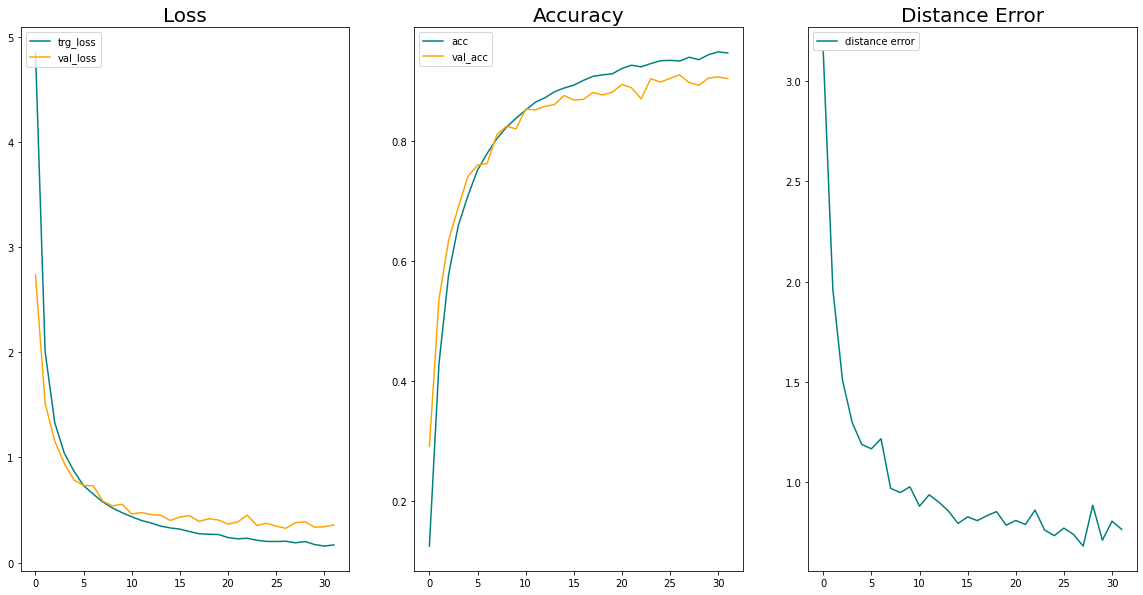

<Figure size 1440x720 with 0 Axes>

In [125]:
plt.rcParams['figure.figsize'] = [20, 10]
fig, axs = plt.subplots(1,3)

axs[0].plot(epochs, loss, color='teal', label='trg_loss')
axs[0].plot(epochs, val_loss, color='orange', label='val_loss')
axs[0].legend(loc='upper left')
axs[0].set_title('Loss', fontsize=20)

axs[1].plot(epochs, acc, color='teal', label='acc')
axs[1].plot(epochs, val_acc, color='orange', label='val_acc')
axs[1].legend(loc='upper left')
axs[1].set_title('Accuracy', fontsize=20)

axs[2].plot(epochs, rmse, color='teal', label='distance error')
axs[2].legend(loc='upper left')
axs[2].set_title('Distance Error', fontsize=20)

plt.show()
plt.savefig('resnet18_training_results')

In [53]:
print(os.getcwd())
os.chdir('../resnet18')
print(os.getcwd())

/home/jovyan/committed_git/datasets
/home/jovyan/committed_git/resnet18


In [54]:
resnet18_model = Model()
rmse, dist_errors, cdf_vals = resnet18_model.test_model("resnet18.h5")

Largest error: 12.165525060596439, Actual RP index: 779, Predicted RP index: 1591


In [65]:
print(rmse)

0.7402846227851831


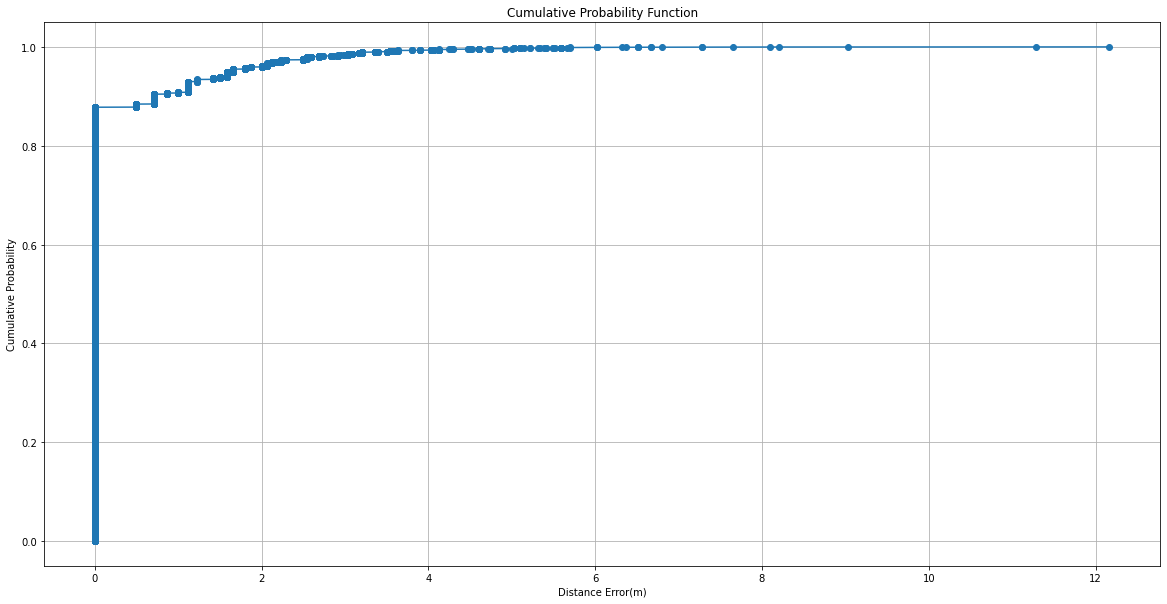

<Figure size 1440x720 with 0 Axes>

In [66]:
plt.rcParams['figure.figsize'] = [20, 10]

plt.plot(dist_errors, cdf_vals, marker='o')
plt.xlabel('Distance Error(m)')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Probability Function')
plt.grid(True)
plt.show()

plt.savefig('resnet18_cdf')

### Diagnosis: Investigate the cause for ~20m error

In [64]:
def get_fingerprints(features, labels, rp_index):

    fingerprints = []
    
    # Get numpy indexs of labels with the interested rp_index
    np_indexes = np.where(labels == rp_index)
    
    # Get the features at these numpy indexes
    for idx in np_indexes:
        fingerprints.append(features[idx])
        
    # Return them in an array
    return fingerprints

# Get all fingerprints for actual RP index 1591
rp1591_fingerprints = get_fingerprints(features, labels, 1591)
print(len(rp1591_fingerprints[0]))

# Get all fingerprints for predicted RP index 2183
rp779_fingerprints = get_fingerprints(features, labels, 779)
print(len(rp779_fingerprints[0]))

ssim_index_ttal = 0

for i in range(len(rp1591_fingerprints[0])):
    
    rp1591_fingerprint = np.expand_dims(rp1591_fingerprints[0][i], axis = 2)
    rp779_fingerprint = np.expand_dims(rp779_fingerprints[0][i], axis = 2)
    ssim_index = tf.image.ssim(rp1591_fingerprint, rp779_fingerprint, max_val=1.0, filter_size=11,
                          filter_sigma=1.5, k1=0.01, k2=0.03).numpy()
    ssim_index_ttal += ssim_index
    
print(f'Average SSIM: {ssim_index_ttal/len(rp1591_fingerprints[0])}')

# Get average of all fingerprint's similarity index
# Sample 3 images to compare and their similarity index

26
31
Average SSIM: 0.03910982092090238


In [ ]:
def get_ssim_value(fp1, fp2):
    
    fp1 = np.expand_dims(fp1, axis = 2)
    fp2 = np.expand_dims(fp2, axies = 2)
    return tf.image.ssim(fp1, fp2, max_val=1.0, filter_size=11,
                          filter_sigma=1.5, k1=0.01, k2=0.03).numpy()

SSIM index for first pair: 0.03809401020407677
SSIM index for second pair: 0.03631441667675972
SSIM index for third pair: 0.017064614221453667


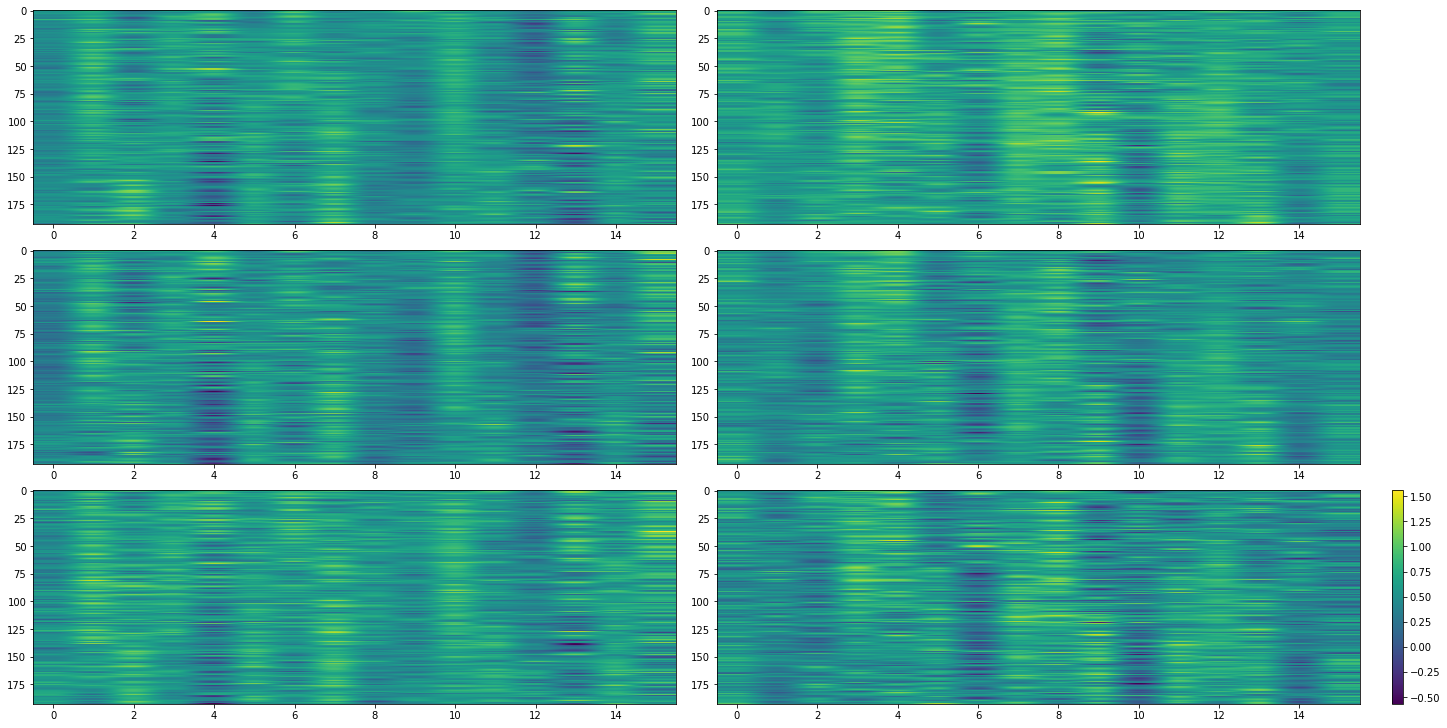

In [77]:
# Sample three random fingerprints and compare them
import random

random_idx1, random_idx2, random_idx3 = random.sample(range(len(rp1591_fingerprints[0])), 3)

plt.rcParams['figure.figsize'] = [20, 10]
fig, axs = plt.subplots(3,2, constrained_layout = True)

plt.colorbar(plt.imshow(rp1591_fingerprints[0][random_idx1]))
axs[0,0].imshow(rp1591_fingerprints[0][random_idx1], aspect = 'auto')
axs[0,1].imshow(rp779_fingerprints[0][random_idx1], aspect = 'auto')
print(f'SSIM index for first pair: {get_ssim_value(rp1591_fingerprints[0][random_idx1], rp779_fingerprints[0][random_idx1])}')

axs[1,0].imshow(rp1591_fingerprints[0][random_idx2], aspect = 'auto')
axs[1,1].imshow(rp779_fingerprints[0][random_idx2], aspect = 'auto')
print(f'SSIM index for second pair: {get_ssim_value(rp1591_fingerprints[0][random_idx2], rp779_fingerprints[0][random_idx2])}')

axs[2,0].imshow(rp1591_fingerprints[0][random_idx3], aspect = 'auto')
axs[2,1].imshow(rp779_fingerprints[0][random_idx3], aspect = 'auto')
print(f'SSIM index for third pair: {get_ssim_value(rp1591_fingerprints[0][random_idx3], rp779_fingerprints[0][random_idx3])}')

### Try to perform data augmentation while ensuring that all pixel values are positive
- Similar to above data augmentation technique, but include an additional clipping step that clips all negative pixel values to 0

In [92]:
# Note: Every colummn refers to measurements from same frequency channel, at different time intervals
# Add noise according to the mean and std of values along the column
def add_gaussian_noise(feature):
    
    num_rows, num_cols = feature.shape[0], feature.shape[1]
    noisy = feature.copy()
    
    # Iterate along the columns of each image
    for i in range(num_cols):
        
        # Get all values in that same column
        channel_values = feature[:,i]
        channel_std = np.std(channel_values)
        channel_mean = np.mean(channel_values)
        
        # Create normal distribution according to std of values with mean 0
        gauss = np.random.normal(0, 2 * channel_std, (num_rows))
        noisy[:,i] = feature[:,i] + gauss
    
    # Additional step of clipping to ensure no negative pixels
    noisy[noisy < 0] = 0

    feature = np.expand_dims(feature, axis = 2)
    noisy = np.expand_dims(noisy, axis = 2)
    

    ssim_value = tf.image.ssim(feature, noisy, max_val=1.0, filter_size=11,
                      filter_sigma=1.5, k1=0.01, k2=0.03).numpy()

    # plt.imshow(noisy, aspect = 'auto')
    return (ssim_value, noisy)

In [97]:
# This function takes in dataset in the numpy format
import h5py
import numpy as np
import tensorflow as tf

def augment_ds(filename):
    
    # Open HDF5 file and access the dataset

    hdf5_file = h5py.File(filename, 'r')

    features_dataset = hdf5_file['features']
    labels_dataset = hdf5_file['labels']['position']

    # Convert HDF5 dataset to NumPy array
    features = np.array(features_dataset)
    labels = np.array(labels_dataset)

    # Prepare features for dataset
    # Retrieve features from the first UE and transpose the individual matrix
    features_transposed = np.zeros((3876,193,16), dtype = np.float64)
    for i in range(len(features)):
        features_transposed[i] = features[i][0].T

    # Prepare labels for dataset
    count = 0
    rp_dict = {}
    # For labels, have a shape of (1,) where that number represents the class of that coordinate

    for label in labels:
        rp_dict[count] = label
        count += 1

    labels = np.array([i for i in range(3876)])

    # Close the HDF5 file
    hdf5_file.close()

    # Currently, for features, have features from 3876 reference points, from 4 UEs, for (16,193) matrices
    print(features_transposed.shape)
    print(labels.shape)
   
    generated_features = []
    generated_coords = []
    
    # Iterate through each feature
    for index, feature in enumerate(features_transposed):
            
        generated_count = 0
        attempts = 0
        
        # while 5 noisy images have not been generated yet,
        while generated_count < 10:
            
            if attempts > 50:
                print(f'Unable to generate data. Index: {index}')
                break
                
            similarity_val, noisy_img = add_gaussian_noise(feature)
            
            # if images are not similar enough,
            if similarity_val >= 0.5:
                generated_features.append(noisy_img)
                generated_coords.append(index)
                generated_count += 1
            
            attempts += 1
            
    print("Finish augmenting")
    np_generated_features = np.array(generated_features)
    np_generated_features = np.squeeze(np_generated_features, axis=(3,))
    np_generated_coords = np.array(generated_coords)
   
    print("Finish making numpy arrays")

    all_features = np.concatenate((features_transposed, np_generated_features), axis = 0)
    all_coords = np.concatenate((labels, np_generated_coords), axis = 0)
    
    print("Finish concatenating numpy arrays")

    return all_features, all_coords

In [140]:
print(os.getcwd())
os.chdir('../datasets')
print(os.getcwd())

/home/jovyan/committed_git/resnet18
/home/jovyan/committed_git/datasets


In [99]:
# filename = 'dataset_SNR10_outdoor.mat'
features_snr10, coords_snr10 = augment_ds('dataset_SNR10_outdoor.mat')
print(features_snr10.shape, coords_snr10.shape)

(3876, 193, 16)
(3876,)
Unable to generate data. Index: 135
Unable to generate data. Index: 165
Unable to generate data. Index: 234
Unable to generate data. Index: 235
Unable to generate data. Index: 236
Unable to generate data. Index: 237
Unable to generate data. Index: 265
Unable to generate data. Index: 266
Unable to generate data. Index: 267
Unable to generate data. Index: 299
Unable to generate data. Index: 332
Unable to generate data. Index: 333
Unable to generate data. Index: 336
Unable to generate data. Index: 338
Unable to generate data. Index: 339
Unable to generate data. Index: 362
Unable to generate data. Index: 365
Unable to generate data. Index: 366
Unable to generate data. Index: 371
Unable to generate data. Index: 372
Unable to generate data. Index: 373
Unable to generate data. Index: 396
Unable to generate data. Index: 397
Unable to generate data. Index: 399
Unable to generate data. Index: 400
Unable to generate data. Index: 401
Unable to generate data. Index: 402
Unab

In [100]:
# filename = 'dataset_SNR20_outdoor.mat'
features_snr20, coords_snr20 = augment_ds('dataset_SNR20_outdoor.mat')
print(features_snr20.shape, coords_snr20.shape)

(3876, 193, 16)
(3876,)
Unable to generate data. Index: 234
Unable to generate data. Index: 235
Unable to generate data. Index: 236
Unable to generate data. Index: 237
Unable to generate data. Index: 265
Unable to generate data. Index: 266
Unable to generate data. Index: 332
Unable to generate data. Index: 333
Unable to generate data. Index: 338
Unable to generate data. Index: 339
Unable to generate data. Index: 362
Unable to generate data. Index: 365
Unable to generate data. Index: 366
Unable to generate data. Index: 371
Unable to generate data. Index: 372
Unable to generate data. Index: 396
Unable to generate data. Index: 397
Unable to generate data. Index: 399
Unable to generate data. Index: 401
Unable to generate data. Index: 402
Unable to generate data. Index: 405
Unable to generate data. Index: 407
Unable to generate data. Index: 431
Unable to generate data. Index: 432
Unable to generate data. Index: 433
Unable to generate data. Index: 435
Unable to generate data. Index: 436
Unab

In [101]:
# filename = 'dataset_SNR50_outdoor.mat'
features_snr50, coords_snr50 = augment_ds('dataset_SNR50_outdoor.mat')
print(features_snr50.shape, coords_snr50.shape)

(3876, 193, 16)
(3876,)
Unable to generate data. Index: 234
Unable to generate data. Index: 235
Unable to generate data. Index: 236
Unable to generate data. Index: 237
Unable to generate data. Index: 265
Unable to generate data. Index: 266
Unable to generate data. Index: 332
Unable to generate data. Index: 333
Unable to generate data. Index: 338
Unable to generate data. Index: 339
Unable to generate data. Index: 362
Unable to generate data. Index: 365
Unable to generate data. Index: 366
Unable to generate data. Index: 371
Unable to generate data. Index: 372
Unable to generate data. Index: 396
Unable to generate data. Index: 397
Unable to generate data. Index: 399
Unable to generate data. Index: 401
Unable to generate data. Index: 402
Unable to generate data. Index: 405
Unable to generate data. Index: 407
Unable to generate data. Index: 431
Unable to generate data. Index: 432
Unable to generate data. Index: 433
Unable to generate data. Index: 435
Unable to generate data. Index: 436
Unab

In [102]:
features = np.concatenate((features_snr10, features_snr20, features_snr50), axis = 0)
labels = np.concatenate((coords_snr10, coords_snr20, coords_snr50), axis = 0)

In [103]:
# Confirm shapes to confirm correctness
print(features.shape, labels.shape)

# Save data into numpy files
np.save('augmented_features_10_v2_ds', features)
np.save('augmented_labels_10_v2_ds', labels)

(89628, 193, 16) (89628,)


In [141]:
features = np.load('augmented_features_10_v2_ds.npy')
labels = np.load('augmented_labels_10_v2_ds.npy')
X = features
y = labels

# random_state = 42 to always ensure same split of dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [127]:
print(os.getcwd())
os.chdir('../resnet18')
print(os.getcwd())

/home/jovyan/committed_git/datasets
/home/jovyan/committed_git/resnet18


In [108]:
resnet18_model2 = Model()
trg_results = resnet18_model2.train_model()

Epoch 1/100
1121/1121 [==============================] - ETA: 0s - loss: 4.9263 - accuracy: 0.1171

Epoch End - Custom Validation Callback
1121/1121 [==============================] - 20s 17ms/step - loss: 4.9263 - accuracy: 0.1171 - val_loss: 2.6376 - val_accuracy: 0.3112 - rmse: 2.9438
Epoch 2/100
1119/1121 [============================>.] - ETA: 0s - loss: 1.9844 - accuracy: 0.4307

Epoch End - Custom Validation Callback
1121/1121 [==============================] - 18s 16ms/step - loss: 1.9838 - accuracy: 0.4308 - val_loss: 1.5195 - val_accuracy: 0.5347 - rmse: 1.8971
Epoch 3/100
1118/1121 [============================>.] - ETA: 0s - loss: 1.2683 - accuracy: 0.5946

Epoch End - Custom Validation Callback
1121/1121 [==============================] - 18s 16ms/step - loss: 1.2680 - accuracy: 0.5948 - val_loss: 1.0915 - val_accuracy: 0.6458 - rmse: 1.4907
Epoch 4/100
1118/1121 [============================>.] - ETA: 0s - loss: 0.9811 - accuracy: 0.6738

Epoch End - Custom Validation Cal

In [109]:
loss = trg_results.history['loss']
acc = trg_results.history['accuracy']
val_loss = trg_results.history['val_loss']
val_acc = trg_results.history['val_accuracy']
rmse = trg_results.history['rmse']
epochs = [i for i in range(len(rmse))]

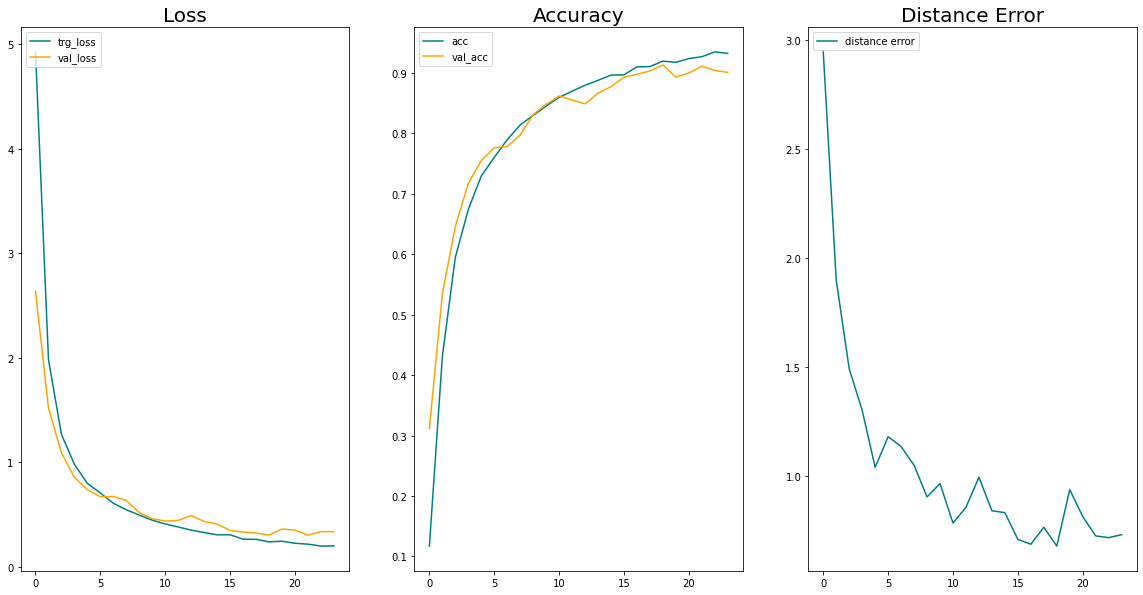

<Figure size 1440x720 with 0 Axes>

In [110]:
plt.rcParams['figure.figsize'] = [20, 10]
fig, axs = plt.subplots(1,3)

axs[0].plot(epochs, loss, color='teal', label='trg_loss')
axs[0].plot(epochs, val_loss, color='orange', label='val_loss')
axs[0].legend(loc='upper left')
axs[0].set_title('Loss', fontsize=20)

axs[1].plot(epochs, acc, color='teal', label='acc')
axs[1].plot(epochs, val_acc, color='orange', label='val_acc')
axs[1].legend(loc='upper left')
axs[1].set_title('Accuracy', fontsize=20)

axs[2].plot(epochs, rmse, color='teal', label='distance error')
axs[2].legend(loc='upper left')
axs[2].set_title('Distance Error', fontsize=20)

plt.show()
plt.savefig('resnet18_training_results')

In [128]:
print(os.getcwd())
os.chdir('../datasets')
print(os.getcwd())

/home/jovyan/committed_git/resnet18
/home/jovyan/committed_git/datasets


In [129]:
# Get dictionary of class and reference point coordinates to calculate rmse later on

import h5py
import numpy as np
import tensorflow as tf

# Open HDF5 file and access the dataset
filename = 'dataset_SNR20_outdoor.mat'
hdf5_file = h5py.File(filename, 'r')

features_dataset = hdf5_file['features']
labels_dataset = hdf5_file['labels']['position']

# Convert HDF5 dataset to NumPy array
features = np.array(features_dataset)
labels = np.array(labels_dataset)

# Prepare features for dataset
# Retrieve features from the first UE and transpose the individual matrix
features_transposed = np.zeros((3876,193,16), dtype = np.float64)
for i in range(len(features)):
    features_transposed[i] = features[i][0].T

# Prepare labels for dataset
count = 0
rp_dict = {}
# For labels, have a shape of (1,) where that number represents the class of that coordinate

for label in labels:
    rp_dict[count] = label
    count += 1

labels = np.array([i for i in range(3876)])

# Close the HDF5 file
hdf5_file.close()

# Currently, for features, have features from 3876 reference points, from 4 UEs, for (16,193) matrices
print(features_transposed.shape)
print(labels.shape)

dataset = tf.data.Dataset.from_tensor_slices((features_transposed, labels))
dataset = dataset.map(lambda x,y : (x, tf.expand_dims(y, axis = 0)))

print(dataset)

(3876, 193, 16)
(3876,)
<MapDataset element_spec=(TensorSpec(shape=(193, 16), dtype=tf.float64, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))>


In [130]:
print(os.getcwd())
os.chdir('../resnet18')
print(os.getcwd())

/home/jovyan/committed_git/datasets
/home/jovyan/committed_git/resnet18


In [134]:
rmse_v2, dist_errors_v2, cdf_vals_v2 = resnet18_model.test_model("resnet18_v2.h5")

Largest error: 19.685019685029527, Actual RP index: 2638, Predicted RP index: 1872


In [135]:
print(rmse_v2)

0.6781215399460101


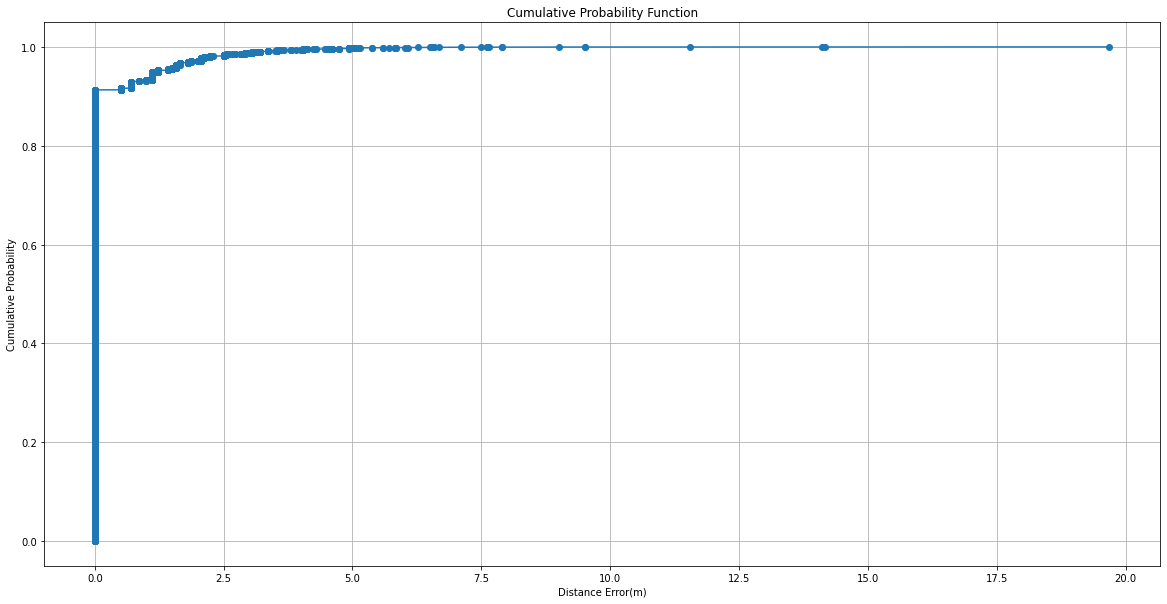

<Figure size 1440x720 with 0 Axes>

In [136]:
plt.rcParams['figure.figsize'] = [20, 10]

plt.plot(dist_errors_v2, cdf_vals_v2, marker='o')
plt.xlabel('Distance Error(m)')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Probability Function')
plt.grid(True)
plt.show()

plt.savefig('resnet18_cdf')

In [144]:
def get_fingerprints(features, labels, rp_index):

    fingerprints = []
    
    # Get numpy indexs of labels with the interested rp_index
    np_indexes = np.where(labels == rp_index)
    
    # Get the features at these numpy indexes
    for idx in np_indexes:
        fingerprints.append(features[idx])
        
    # Return them in an array
    return fingerprints

# Get all fingerprints for actual RP index 1591
rp2638_fingerprints = get_fingerprints(features, labels, 2638)
print(len(rp2638_fingerprints[0]))

# Get all fingerprints for predicted RP index 2183
rp1872_fingerprints = get_fingerprints(features, labels, 1872)
print(len(rp1872_fingerprints[0]))

ssim_index_ttal = 0

for i in range(len(rp1591_fingerprints[0])):
    
    rp2638_fingerprint = np.expand_dims(rp2638_fingerprints[0][i], axis = 2)
    rp1872_fingerprint = np.expand_dims(rp1872_fingerprints[0][i], axis = 2)
    ssim_index = tf.image.ssim(rp1591_fingerprint, rp779_fingerprint, max_val=1.0, filter_size=11,
                          filter_sigma=1.5, k1=0.01, k2=0.03).numpy()
    ssim_index_ttal += ssim_index
    
print(f'Average SSIM: {ssim_index_ttal/len(rp2638_fingerprints[0])}')

3
33
Average SSIM: -0.09483343362808228


SSIM index for first pair: -0.19475682079792023
SSIM index for second pair: -0.07943437248468399
SSIM index for third pair: -0.09483343362808228


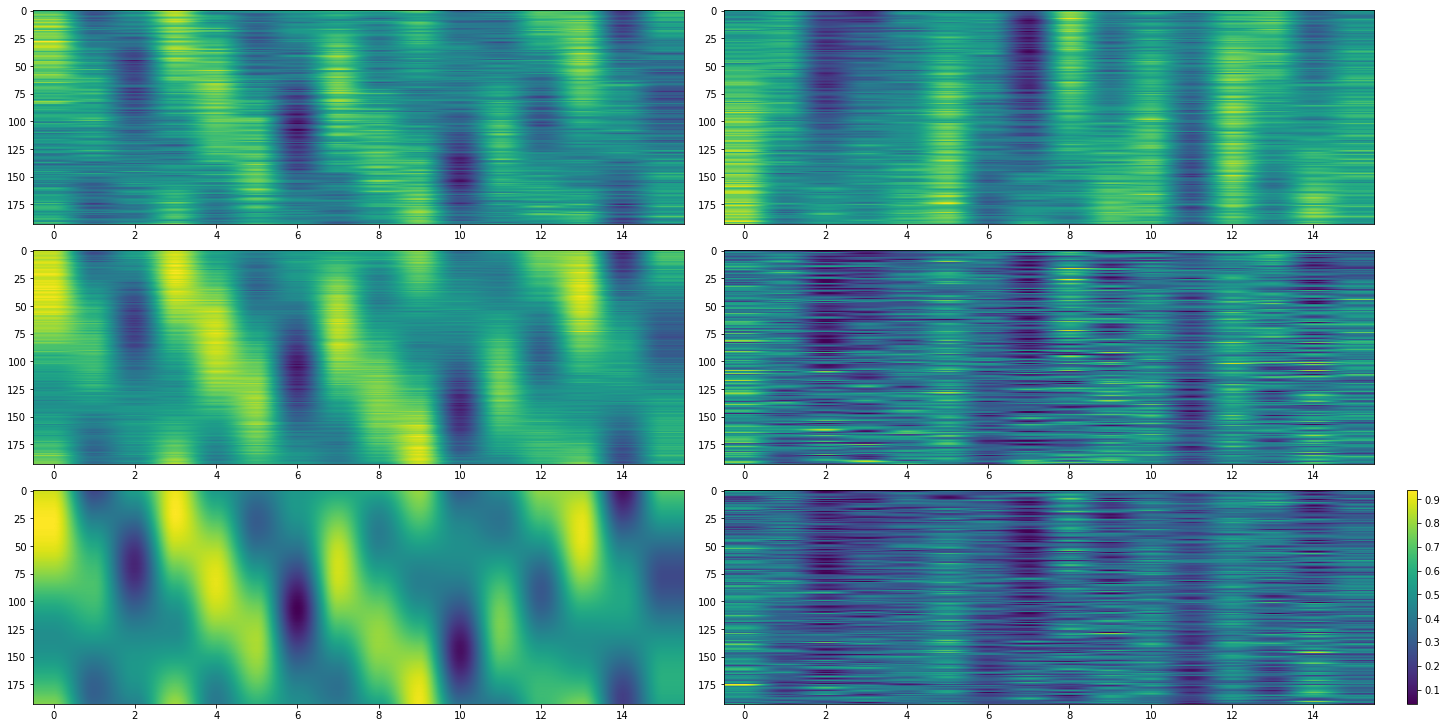

In [145]:
# Sample three random fingerprints and compare them
import random

random_idx1, random_idx2, random_idx3 = random.sample(range(len(rp1591_fingerprints[0])), 3)

plt.rcParams['figure.figsize'] = [20, 10]
fig, axs = plt.subplots(3,2, constrained_layout = True)

plt.colorbar(plt.imshow(rp2638_fingerprints[0][random_idx1]))
axs[0,0].imshow(rp2638_fingerprints[0][random_idx1], aspect = 'auto')
axs[0,1].imshow(rp1872_fingerprints[0][random_idx1], aspect = 'auto')
print(f'SSIM index for first pair: {get_ssim_value(rp2638_fingerprints[0][random_idx1], rp1872_fingerprints[0][random_idx1])}')

axs[1,0].imshow(rp2638_fingerprints[0][random_idx2], aspect = 'auto')
axs[1,1].imshow(rp1872_fingerprints[0][random_idx2], aspect = 'auto')
print(f'SSIM index for second pair: {get_ssim_value(rp2638_fingerprints[0][random_idx2], rp1872_fingerprints[0][random_idx2])}')

axs[2,0].imshow(rp2638_fingerprints[0][random_idx3], aspect = 'auto')
axs[2,1].imshow(rp1872_fingerprints[0][random_idx3], aspect = 'auto')
print(f'SSIM index for third pair: {get_ssim_value(rp2638_fingerprints[0][random_idx3], rp1872_fingerprints[0][random_idx3])}')